In [1]:
!pip install "jax[cuda12]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html

Looking in links: https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
  Using cached jax-0.6.0-py3-none-any.whl.metadata (22 kB)
  Using cached jaxlib-0.6.0-cp311-cp311-manylinux2014_x86_64.whl.metadata (1.2 kB)
  Using cached ml_dtypes-0.5.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (21 kB)
  Using cached jax_cuda12_plugin-0.6.0-cp311-cp311-manylinux2014_x86_64.whl.metadata (1.4 kB)
  Using cached jax_cuda12_pjrt-0.6.0-py3-none-manylinux2014_x86_64.whl.metadata (492 bytes)
  Using cached nvidia_cuda_nvcc_cu12-12.8.93-py3-none-manylinux2010_x86_64.manylinux_2_12_x86_64.whl.metadata (1.7 kB)
  Using cached nvidia_cudnn_cu12-9.8.0.87-py3-none-manylinux_2_27_x86_64.whl.metadata (1.8 kB)
Using cached jax_cuda12_plugin-0.6.0-cp311-cp311-manylinux2014_x86_64.whl (15.8 MB)
Using cached jax_cuda12_pjrt-0.6.0-py3-none-manylinux2014_x86_64.whl (123.4 MB)
Using cached jaxlib-0.6.0-cp311-cp311-manylinux2014_x86_64.whl (87.8 MB)
Using cached ml_dtypes-0.5.1-

In [2]:
import jax
import jax.numpy as jnp
from jax import random, grad, value_and_grad, lax
import jax.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle
import tarfile
from urllib import request
from tqdm import tqdm
from jax.tree_util import tree_map
from functools import partial

In [3]:
# Model Configuration
class CNNConfig:
    def __init__(self):
        self.input_shape = (1, 32, 32, 3)  # (batch_size, height, width, channels) for CIFAR-10
        self.conv1_filters = 64
        self.conv2_filters = 128
        self.conv3_filters = 256
        self.kernel_size = 3
        self.dense_units = 512
        self.output_classes = 10
        # Regularization parameters
        self.weight_decay = 1e-4
        self.dropout_rate = 0.3
        self.batch_norm_momentum = 0.9
        self.use_batch_norm = True
        self.use_dropout = True
        self.use_residual = True
        self.use_global_pooling = True

# Layer implementations
def conv2d(x, w, b, stride=1, padding='SAME'):
    """Convolutional layer implementation"""
    x = jax.lax.conv_general_dilated(
        lhs=x,
        rhs=w,
        window_strides=(stride, stride),
        padding=padding,
        dimension_numbers=('NHWC', 'OIHW', 'NHWC')
    )
    return x + b

def batch_norm(x, scale, bias, mean, var, is_training, momentum=0.9, epsilon=1e-5):
    """Batch normalization layer"""
    if is_training:
        # Calculate batch statistics
        batch_mean = jnp.mean(x, axis=(0, 1, 2), keepdims=True)
        batch_var = jnp.var(x, axis=(0, 1, 2), keepdims=True)
        
        # Update running stats using exponential moving average
        new_mean = momentum * mean + (1 - momentum) * batch_mean
        new_var = momentum * var + (1 - momentum) * batch_var
        
        # Normalize using batch statistics
        x_normalized = (x - batch_mean) / jnp.sqrt(batch_var + epsilon)
        
        # Return normalized output and updated statistics
        return scale * x_normalized + bias, new_mean, new_var
    else:
        # Normalize using running statistics for inference
        x_normalized = (x - mean) / jnp.sqrt(var + epsilon)
        return scale * x_normalized + bias, mean, var

def relu(x):
    """ReLU activation function"""
    return jnp.maximum(x, 0)

def max_pool(x, pool_size=2, stride=2, padding='VALID'):
    """Max pooling layer implementation"""
    return jax.lax.reduce_window(
        x,
        -jnp.inf,
        jax.lax.max,
        window_dimensions=(1, pool_size, pool_size, 1),
        window_strides=(1, stride, stride, 1),
        padding=padding
    )

def dropout(x, rate, rng):
    """Dropout regularization"""
    if rate == 0.0:
        return x
    
    keep_prob = 1.0 - rate
    mask = random.bernoulli(rng, keep_prob, shape=x.shape)
    return x * mask / keep_prob

def dense(x, w, b):
    """Fully connected layer implementation"""
    return jnp.dot(x, w) + b

def global_avg_pool(x):
    """Global average pooling layer"""
    return jnp.mean(x, axis=(1, 2))



def residual_block(x, params, bn_stats, is_training, rng, block_idx, config):
    """Residual block with batch normalization and dropout"""
    # Store input
    orig_x = x
    input_channels = x.shape[-1]
    
    # First convolution
    x = conv2d(x, params[f'conv{block_idx}a_w'], params[f'conv{block_idx}a_b'])
    x, bn_stats[f'bn{block_idx}a_mean'], bn_stats[f'bn{block_idx}a_var'] = batch_norm(
        x, params[f'bn{block_idx}a_scale'], params[f'bn{block_idx}a_bias'],
        bn_stats[f'bn{block_idx}a_mean'], bn_stats[f'bn{block_idx}a_var'],
        is_training, config.batch_norm_momentum
    )
    x = relu(x)
    
    # Second convolution
    x = conv2d(x, params[f'conv{block_idx}b_w'], params[f'conv{block_idx}b_b'])
    x, bn_stats[f'bn{block_idx}b_mean'], bn_stats[f'bn{block_idx}b_var'] = batch_norm(
        x, params[f'bn{block_idx}b_scale'], params[f'bn{block_idx}b_bias'],
        bn_stats[f'bn{block_idx}b_mean'], bn_stats[f'bn{block_idx}b_var'],
        is_training, config.batch_norm_momentum
    )
    
    # Check if projection is needed
    if input_channels != x.shape[-1]:
        # Always use projection if dimensions don't match
        projection_key = f'conv{block_idx}_proj_w'
        # Ensure the projection parameters exist
        if projection_key in params:
            orig_x = conv2d(orig_x, params[projection_key], params[f'conv{block_idx}_proj_b'])
            orig_x, bn_stats[f'bn{block_idx}_proj_mean'], bn_stats[f'bn{block_idx}_proj_var'] = batch_norm(
                orig_x, params[f'bn{block_idx}_proj_scale'], params[f'bn{block_idx}_proj_bias'],
                bn_stats[f'bn{block_idx}_proj_mean'], bn_stats[f'bn{block_idx}_proj_var'],
                is_training, config.batch_norm_momentum
            )
        else:
            # If projection parameters don't exist, skip the residual connection
            # This is a fallback and shouldn't happen with proper initialization
            orig_x = x
    
    # Add residual connection and apply ReLU
    x = x + orig_x
    x = relu(x)
    
    # Apply dropout if training
    if is_training and config.use_dropout:
        rng, dropout_rng = random.split(rng)
        x = dropout(x, rate=config.dropout_rate/2, rng=dropout_rng)  # Less dropout in conv layers
    
    return x, bn_stats, rng

def initialize_improved_cnn_params(rng, config):
    """Initialize CNN model parameters with He initialization and batch norm params"""
    params = {}
    bn_stats = {}  # For tracking running mean and variance
    
    subkeys = random.split(rng, 15)  # Generate more subkeys for randomness
    key_idx = 0
    
    # --- First Block ---
    # First convolution layer (3->64 channels, needs projection)
    params['conv1a_w'] = random.normal(subkeys[key_idx], (
        config.conv1_filters, config.input_shape[-1], 
        config.kernel_size, config.kernel_size)
    ) * jnp.sqrt(2/(config.kernel_size**2 * config.input_shape[-1]))
    params['conv1a_b'] = jnp.zeros((config.conv1_filters,))
    key_idx += 1
    
    # Batch norm for first conv
    params['bn1a_scale'] = jnp.ones((config.conv1_filters,))
    params['bn1a_bias'] = jnp.zeros((config.conv1_filters,))
    bn_stats['bn1a_mean'] = jnp.zeros((1, 1, 1, config.conv1_filters))
    bn_stats['bn1a_var'] = jnp.ones((1, 1, 1, config.conv1_filters))
    
    # Second convolution in block 1
    params['conv1b_w'] = random.normal(subkeys[key_idx], (
        config.conv1_filters, config.conv1_filters, 
        config.kernel_size, config.kernel_size)
    ) * jnp.sqrt(2/(config.kernel_size**2 * config.conv1_filters))
    params['conv1b_b'] = jnp.zeros((config.conv1_filters,))
    key_idx += 1
    
    # Batch norm for second conv
    params['bn1b_scale'] = jnp.ones((config.conv1_filters,))
    params['bn1b_bias'] = jnp.zeros((config.conv1_filters,))
    bn_stats['bn1b_mean'] = jnp.zeros((1, 1, 1, config.conv1_filters))
    bn_stats['bn1b_var'] = jnp.ones((1, 1, 1, config.conv1_filters))
    
    # Projection for first block (3->64 channels)
    params['conv1_proj_w'] = random.normal(subkeys[key_idx], (
        config.conv1_filters, config.input_shape[-1], 1, 1)
    ) * jnp.sqrt(2/(1 * config.input_shape[-1]))
    params['conv1_proj_b'] = jnp.zeros((config.conv1_filters,))
    key_idx += 1
    
    # Batch norm for projection
    params['bn1_proj_scale'] = jnp.ones((config.conv1_filters,))
    params['bn1_proj_bias'] = jnp.zeros((config.conv1_filters,))
    bn_stats['bn1_proj_mean'] = jnp.zeros((1, 1, 1, config.conv1_filters))
    bn_stats['bn1_proj_var'] = jnp.ones((1, 1, 1, config.conv1_filters))
    
    # --- Second Block ---
    # First convolution (64->128 channels)
    params['conv2a_w'] = random.normal(subkeys[key_idx], (
        config.conv2_filters, config.conv1_filters, 
        config.kernel_size, config.kernel_size)
    ) * jnp.sqrt(2/(config.kernel_size**2 * config.conv1_filters))
    params['conv2a_b'] = jnp.zeros((config.conv2_filters,))
    key_idx += 1
    
    # Batch norm
    params['bn2a_scale'] = jnp.ones((config.conv2_filters,))
    params['bn2a_bias'] = jnp.zeros((config.conv2_filters,))
    bn_stats['bn2a_mean'] = jnp.zeros((1, 1, 1, config.conv2_filters))
    bn_stats['bn2a_var'] = jnp.ones((1, 1, 1, config.conv2_filters))
    
    # Second convolution
    params['conv2b_w'] = random.normal(subkeys[key_idx], (
        config.conv2_filters, config.conv2_filters, 
        config.kernel_size, config.kernel_size)
    ) * jnp.sqrt(2/(config.kernel_size**2 * config.conv2_filters))
    params['conv2b_b'] = jnp.zeros((config.conv2_filters,))
    key_idx += 1
    
    # Batch norm
    params['bn2b_scale'] = jnp.ones((config.conv2_filters,))
    params['bn2b_bias'] = jnp.zeros((config.conv2_filters,))
    bn_stats['bn2b_mean'] = jnp.zeros((1, 1, 1, config.conv2_filters))
    bn_stats['bn2b_var'] = jnp.ones((1, 1, 1, config.conv2_filters))
    
    # Projection for residual connection (64->128)
    params['conv2_proj_w'] = random.normal(subkeys[key_idx], (
        config.conv2_filters, config.conv1_filters, 1, 1)
    ) * jnp.sqrt(2/(1 * config.conv1_filters))
    params['conv2_proj_b'] = jnp.zeros((config.conv2_filters,))
    key_idx += 1
    
    # Batch norm for projection
    params['bn2_proj_scale'] = jnp.ones((config.conv2_filters,))
    params['bn2_proj_bias'] = jnp.zeros((config.conv2_filters,))
    bn_stats['bn2_proj_mean'] = jnp.zeros((1, 1, 1, config.conv2_filters))
    bn_stats['bn2_proj_var'] = jnp.ones((1, 1, 1, config.conv2_filters))
    
    # --- Third Block ---
    # First convolution (128->256 channels)
    params['conv3a_w'] = random.normal(subkeys[key_idx], (
        config.conv3_filters, config.conv2_filters, 
        config.kernel_size, config.kernel_size)
    ) * jnp.sqrt(2/(config.kernel_size**2 * config.conv2_filters))
    params['conv3a_b'] = jnp.zeros((config.conv3_filters,))
    key_idx += 1
    
    # Batch norm
    params['bn3a_scale'] = jnp.ones((config.conv3_filters,))
    params['bn3a_bias'] = jnp.zeros((config.conv3_filters,))
    bn_stats['bn3a_mean'] = jnp.zeros((1, 1, 1, config.conv3_filters))
    bn_stats['bn3a_var'] = jnp.ones((1, 1, 1, config.conv3_filters))
    
    # Second convolution
    params['conv3b_w'] = random.normal(subkeys[key_idx], (
        config.conv3_filters, config.conv3_filters, 
        config.kernel_size, config.kernel_size)
    ) * jnp.sqrt(2/(config.kernel_size**2 * config.conv3_filters))
    params['conv3b_b'] = jnp.zeros((config.conv3_filters,))
    key_idx += 1
    
    # Batch norm
    params['bn3b_scale'] = jnp.ones((config.conv3_filters,))
    params['bn3b_bias'] = jnp.zeros((config.conv3_filters,))
    bn_stats['bn3b_mean'] = jnp.zeros((1, 1, 1, config.conv3_filters))
    bn_stats['bn3b_var'] = jnp.ones((1, 1, 1, config.conv3_filters))
    
    # Projection for residual connection (128->256)
    params['conv3_proj_w'] = random.normal(subkeys[key_idx], (
        config.conv3_filters, config.conv2_filters, 1, 1)
    ) * jnp.sqrt(2/(1 * config.conv2_filters))
    params['conv3_proj_b'] = jnp.zeros((config.conv3_filters,))
    key_idx += 1
    
    # Batch norm for projection
    params['bn3_proj_scale'] = jnp.ones((config.conv3_filters,))
    params['bn3_proj_bias'] = jnp.zeros((config.conv3_filters,))
    bn_stats['bn3_proj_mean'] = jnp.zeros((1, 1, 1, config.conv3_filters))
    bn_stats['bn3_proj_var'] = jnp.ones((1, 1, 1, config.conv3_filters))
    
    # Calculate dense layer input dim based on whether we use global pooling
    if config.use_global_pooling:
        dense_input_dim = config.conv3_filters
    else:
        # Each max pool halves the dimensions
        h, w = 32, 32
        h, w = h // 2, w // 2  # After first block
        h, w = h // 2, w // 2  # After second block 
        h, w = h // 2, w // 2  # After third block
        dense_input_dim = h * w * config.conv3_filters
    
    # Dense layers
    params['dense1_w'] = random.normal(subkeys[key_idx], (dense_input_dim, config.dense_units)) * jnp.sqrt(2/dense_input_dim)
    params['dense1_b'] = jnp.zeros((config.dense_units,))
    key_idx += 1
    
    params['dense2_w'] = random.normal(subkeys[key_idx], (config.dense_units, config.output_classes)) * jnp.sqrt(2/config.dense_units)
    params['dense2_b'] = jnp.zeros((config.output_classes,))
    
    return params, bn_stats

def forward_pass(params, bn_stats, x, is_training, rng, config):
    """Forward pass through the improved CNN model with regularization techniques"""
    # Residual block 1
    x, bn_stats, rng = residual_block(x, params, bn_stats, is_training, rng, 1, config)
    x = max_pool(x)
    
    # Residual block 2
    x, bn_stats, rng = residual_block(x, params, bn_stats, is_training, rng, 2, config)
    x = max_pool(x)
    
    # Residual block 3
    x, bn_stats, rng = residual_block(x, params, bn_stats, is_training, rng, 3, config)
    x = max_pool(x)
    
    # Feature pooling
    if config.use_global_pooling:
        x = global_avg_pool(x)
    else:
        x = x.reshape((x.shape[0], -1))  # Flatten
    
    # Dense layers
    x = dense(x, params['dense1_w'], params['dense1_b'])
    x = relu(x)
    
    # Dropout for fully connected layer
    if is_training and config.use_dropout:
        rng, dropout_rng = random.split(rng)
        x = dropout(x, rate=config.dropout_rate, rng=dropout_rng)
    
    # Output layer
    x = dense(x, params['dense2_w'], params['dense2_b'])
    
    return x, bn_stats, rng

In [4]:
# Optimizers with weight decay
class AdamWOptimizer:
    """Adam optimizer with decoupled weight decay (AdamW)"""
    def __init__(self, learning_rate=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8, weight_decay=1e-4):
        self.learning_rate = learning_rate
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.weight_decay = weight_decay
    
    def init(self, params):
        """Initialize optimizer state"""
        # Return optimizer state instead of storing it as instance variables
        return {
            'm': tree_map(jnp.zeros_like, params),
            'v': tree_map(jnp.zeros_like, params),
            't': 0
        }
    
    def update(self, params, grads, opt_state):
        """Update parameters using gradients and optimizer state"""
        # Unpack optimizer state
        m, v, t = opt_state['m'], opt_state['v'], opt_state['t']
        
        # Increment timestep
        t = t + 1
        
        # Update biased first moment estimate
        m = tree_map(
            lambda m_i, g_i: self.beta1 * m_i + (1 - self.beta1) * g_i, 
            m, grads
        )
        
        # Update biased second raw moment estimate
        v = tree_map(
            lambda v_i, g_i: self.beta2 * v_i + (1 - self.beta2) * (g_i * g_i), 
            v, grads
        )
        
        # Compute bias-corrected first moment estimate
        m_hat = tree_map(
            lambda m_i: m_i / (1 - self.beta1 ** t), 
            m
        )
        
        # Compute bias-corrected second raw moment estimate
        v_hat = tree_map(
            lambda v_i: v_i / (1 - self.beta2 ** t), 
            v
        )
        
        # Update parameters with Adam and weight decay separately
        updated_params = tree_map(
            lambda p, m_h, v_h: (1 - self.weight_decay * self.learning_rate) * p - 
                              self.learning_rate * m_h / (jnp.sqrt(v_h) + self.epsilon),
            params, m_hat, v_hat
        )
        
        # Return updated parameters and optimizer state
        updated_opt_state = {'m': m, 'v': v, 't': t}
        return updated_params, updated_opt_state

In [5]:
# Learning rate schedules
def cosine_decay_schedule(initial_lr, epoch, total_epochs, warmup_epochs=5):
    """Cosine annealing learning rate schedule with warmup"""
    if epoch < warmup_epochs:
        # Linear warmup
        return initial_lr * (epoch + 1) / warmup_epochs
    else:
        # Cosine decay
        decay_epochs = total_epochs - warmup_epochs
        epoch_adj = epoch - warmup_epochs
        return initial_lr * 0.5 * (1 + jnp.cos(jnp.pi * epoch_adj / decay_epochs))

# Metrics and Loss Function
def cross_entropy_loss(params, bn_stats, batch_images, batch_labels, is_training, rng, config):
    """Compute cross entropy loss with L2 regularization for a batch of images"""
    # Get model predictions
    logits, updated_bn_stats, new_rng = forward_pass(params, bn_stats, batch_images, is_training, rng, config)
    
    # Compute log probabilities
    log_probs = nn.log_softmax(logits)
    
    # Convert labels to one-hot encoding
    one_hot = jax.nn.one_hot(batch_labels, config.output_classes)
    
    # Compute cross entropy loss (negative log likelihood)
    ce_loss = -jnp.sum(one_hot * log_probs) / batch_images.shape[0]
    
    # Note: Weight decay is applied separately in the optimizer, not in the loss
    
    return ce_loss, updated_bn_stats, new_rng

def compute_accuracy(params, bn_stats, batch_images, batch_labels, rng, config):
    """Compute accuracy for a batch of images"""
    # Get model predictions in inference mode (is_training=False)
    logits, _, _ = forward_pass(params, bn_stats, batch_images, False, rng, config)
    
    # Get predicted class indices
    preds = jnp.argmax(logits, axis=-1)
    
    # Compute accuracy
    return jnp.mean(preds == batch_labels)

def precision_recall_f1(params, bn_stats, batch_images, batch_labels, rng, config):
    """Compute precision, recall, and F1 score for a batch of images"""
    # Get model predictions in inference mode
    logits, _, _ = forward_pass(params, bn_stats, batch_images, False, rng, config)
    preds = jnp.argmax(logits, axis=-1)
    
    # Number of classes (CIFAR-10 has 10 classes)
    num_classes = 10
    
    # Initialize lists for metrics
    precision_list, recall_list, f1_list = [], [], []
    
    # Compute metrics for each class
    for cls in range(num_classes):
        # True positives, false positives, false negatives
        tp = jnp.sum((preds == cls) & (batch_labels == cls))
        fp = jnp.sum((preds == cls) & (batch_labels != cls))
        fn = jnp.sum((preds != cls) & (batch_labels == cls))
        
        # Compute precision, recall, and F1 with small epsilon to avoid division by zero
        epsilon = 1e-8
        precision = tp / (tp + fp + epsilon)
        recall = tp / (tp + fn + epsilon)
        f1 = 2 * precision * recall / (precision + recall + epsilon)
        
        precision_list.append(precision)
        recall_list.append(recall)
        f1_list.append(f1)
    
    # Return average metrics across all classes
    return jnp.mean(jnp.array(precision_list)), jnp.mean(jnp.array(recall_list)), jnp.mean(jnp.array(f1_list))


In [6]:
# Data Loading with Augmentation
def download_cifar10(data_dir):
    """Download CIFAR-10 dataset if it doesn't exist"""
    if not os.path.exists(data_dir):
        os.makedirs(data_dir)
    
    # URLs for CIFAR-10 dataset
    base_url = "https://www.cs.toronto.edu/~kriz/"
    train_file = "cifar-10-python.tar.gz"
    train_url = base_url + train_file
    train_path = os.path.join(data_dir, train_file)
    
    # Download the dataset if not already present
    if not os.path.exists(train_path):
        print(f"Downloading CIFAR-10 dataset from {train_url}...")
        request.urlretrieve(train_url, train_path)
        print("Download complete.")
    else:
        print("CIFAR-10 dataset already exists.")
    
    return train_path

def unpickle(file):
    """Unpickle CIFAR-10 batch files"""
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

def load_cifar10_raw(data_dir):
    """
    Load CIFAR-10 dataset from raw files
    
    Returns:
        Tuple of (train_images, train_labels, test_images, test_labels)
    """
    # Download dataset if needed
    cifar_path = download_cifar10(data_dir)
    
    # Extract files if not already extracted
    cifar_dir = os.path.join(data_dir, "cifar-10-batches-py")
    if not os.path.exists(cifar_dir):
        print("Extracting CIFAR-10 files...")
        with tarfile.open(cifar_path, 'r:gz') as tar:
            tar.extractall(path=data_dir)
        print("Extraction complete.")
    
    # Load training data (batches 1-5)
    train_images = []
    train_labels = []
    for i in range(1, 6):
        batch_file = os.path.join(cifar_dir, f"data_batch_{i}")
        batch_data = unpickle(batch_file)
        train_images.append(batch_data[b'data'])
        train_labels.extend(batch_data[b'labels'])
    
    # Reshape training data
    train_images = np.vstack(train_images).reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
    train_labels = np.array(train_labels)
    
    # Load test data
    test_batch_file = os.path.join(cifar_dir, "test_batch")
    test_data = unpickle(test_batch_file)
    test_images = test_data[b'data'].reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
    test_labels = np.array(test_data[b'labels'])
    
    return train_images, train_labels, test_images, test_labels

# Data augmentation functions
def random_flip(rng, image):
    """Randomly flip image horizontally"""
    flip_rng, rng = random.split(rng)
    should_flip = random.bernoulli(flip_rng, 0.5)
    flipped_image = jnp.fliplr(image)
    return jnp.where(should_flip, flipped_image, image), rng

def random_crop(rng, image, padding=4):
    """Randomly crop image with padding"""
    crop_rng, rng = random.split(rng)
    
    # Pad the image
    padded = jnp.pad(image, ((padding, padding), (padding, padding), (0, 0)), mode='constant')
    
    # Generate random crop coordinates
    h_offset = random.randint(crop_rng, shape=(), minval=0, maxval=2*padding)
    crop_rng, rng = random.split(rng)
    w_offset = random.randint(crop_rng, shape=(), minval=0, maxval=2*padding)
    
    # Perform crop
    cropped = lax.dynamic_slice(padded, (h_offset, w_offset, 0), (32, 32, 3))
    
    return cropped, rng

def random_brightness(rng, image, delta=0.1):
    """Randomly adjust brightness"""
    bright_rng, rng = random.split(rng)
    factor = 1.0 + random.uniform(bright_rng, shape=(), minval=-delta, maxval=delta)
    return jnp.clip(image * factor, 0.0, 1.0), rng

def cutout(rng, image, size=8):
    """Apply cutout augmentation"""
    cutout_rng, h_rng, w_rng, rng = random.split(rng, 4)
    apply_cutout = random.bernoulli(cutout_rng, 0.5)
    
    h, w = image.shape[0], image.shape[1]
    center_h = random.randint(h_rng, shape=(), minval=0, maxval=h)
    center_w = random.randint(w_rng, shape=(), minval=0, maxval=w)
    
    # Calculate cutout boundaries
    lower_h = jnp.maximum(0, center_h - size // 2)
    upper_h = jnp.minimum(h, center_h + size // 2)
    lower_w = jnp.maximum(0, center_w - size // 2)
    upper_w = jnp.minimum(w, center_w + size // 2)
    
    # Create mask indices
    mask_h = jnp.arange(h)[:, jnp.newaxis]
    mask_w = jnp.arange(w)
    
    # Create the mask
    mask = ((mask_h >= lower_h) & (mask_h < upper_h) & 
            (mask_w >= lower_w) & (mask_w < upper_w))
    mask = 1.0 - mask[:, :, jnp.newaxis]  # Invert and add channel dimension
    
    # Apply the mask conditionally
    return jnp.where(apply_cutout, image * mask, image), rng

def apply_augmentation(rng, image):
    """Apply a series of augmentations to an image"""
    # Random horizontal flip
    image, rng = random_flip(rng, image)
    
    # Random crop with padding
    image, rng = random_crop(rng, image)
    
    # Random brightness adjustment
    image, rng = random_brightness(rng, image)
    
    # Cutout augmentation
    image, rng = cutout(rng, image)
    
    return image, rng

def augment_batch(rng, batch_images):
    """Apply augmentation to a batch of images"""
    # Create a new rng for each image
    rngs = random.split(rng, batch_images.shape[0] + 1)
    new_rng = rngs[0]
    
    # Apply augmentation to each image
    augmented_images = []
    for i, image in enumerate(batch_images):
        aug_image, _ = apply_augmentation(rngs[i+1], image)
        augmented_images.append(aug_image)
    
    return jnp.array(augmented_images), new_rng

def create_batches(images, labels, batch_size, shuffle=True):
    """Create batches of data for training/evaluation"""
    num_examples = len(images)
    indices = np.arange(num_examples)
    
    if shuffle:
        np.random.shuffle(indices)
    
    # Create list of batches
    batches = []
    for start_idx in range(0, num_examples, batch_size):
        end_idx = min(start_idx + batch_size, num_examples)
        batch_indices = indices[start_idx:end_idx]
        batches.append((images[batch_indices], labels[batch_indices]))
    
    return batches


In [7]:
def load_cifar10(batch_size=128, seed=0, valid_ratio=0.1):
    """
    Load and preprocess CIFAR-10 dataset with validation split
    
    Args:
        batch_size: Batch size for training/evaluation
        seed: Random seed for shuffling
        valid_ratio: Ratio of training data to use for validation
        
    Returns:
        Tuple of (train_batches, valid_batches, test_batches)
    """
    # Set random seed for reproducibility
    np.random.seed(seed)
    
    # Check if preprocessed data exists in cache
    data_dir = "cifar10_data"
    cache_file = os.path.join(data_dir, "cifar10_preprocessed.pkl")
    if os.path.exists(cache_file):
        print("Loading preprocessed CIFAR-10 data from cache...")
        with open(cache_file, 'rb') as f:
            train_images, train_labels, test_images, test_labels = pickle.load(f)
    else:
        print("Loading CIFAR-10 from raw files...")
        # Load raw data
        train_images, train_labels, test_images, test_labels = load_cifar10_raw(data_dir)
        
        # Preprocess images: normalize to [0,1]
        train_images = train_images.astype(np.float32) / 255.0
        test_images = test_images.astype(np.float32) / 255.0
        
        # Cache the preprocessed data
        os.makedirs(data_dir, exist_ok=True)
        with open(cache_file, 'wb') as f:
            pickle.dump((train_images, train_labels, test_images, test_labels), f)
        print(f"Saved preprocessed data to {cache_file}")
    
    # Create validation split
    num_train = len(train_images)
    num_valid = int(valid_ratio * num_train)
    
    # Shuffle before splitting
    indices = np.random.permutation(num_train)
    valid_indices = indices[:num_valid]
    train_indices = indices[num_valid:]
    
    valid_images, valid_labels = train_images[valid_indices], train_labels[valid_indices]
    train_images, train_labels = train_images[train_indices], train_labels[train_indices]
    
    # Create batches
    train_batches = create_batches(train_images, train_labels, batch_size, shuffle=True)
    valid_batches = create_batches(valid_images, valid_labels, batch_size, shuffle=False)
    test_batches = create_batches(test_images, test_labels, batch_size, shuffle=False)
    
    print(f"Created {len(train_batches)} training batches, {len(valid_batches)} validation batches, and {len(test_batches)} test batches")
    return train_batches, valid_batches, test_batches

def plot_training_curves(train_losses, valid_losses, train_accuracies, valid_accuracies):
    """Plot training and validation curves for loss and accuracy"""
    plt.figure(figsize=(15, 6))
    
    # Loss curve
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(valid_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss Curve')
    plt.grid(True, alpha=0.3)
    
    # Accuracy curve
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(valid_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy Curve')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('cifar10_improved_training_curves.png')
    plt.show()

def select_device(device_type="auto"):
    """
    Select appropriate device for training (CPU/GPU/TPU)
    
    Args:
        device_type: 'cpu', 'gpu', or 'auto' to automatically select
        
    Returns:
        Selected JAX device
    """
    if device_type == "cpu":
        device = jax.devices("cpu")[0]
    elif device_type == "gpu":
        try:
            gpus = jax.devices("gpu")
            if not gpus:
                raise RuntimeError("No GPU found, falling back to CPU")
            device = gpus[0]
        except RuntimeError:
            print("Warning: GPU requested but not available. Using CPU instead.")
            device = jax.devices("cpu")[0]
    else:  # Auto mode
        # Try to use GPU if available, otherwise use CPU
        try:
            gpus = jax.devices("gpu")
            if gpus:
                device = gpus[0]
                print("GPU detected, using GPU for training")
            else:
                device = jax.devices("cpu")[0]
                print("No GPU detected, using CPU for training")
        except:
            device = jax.devices("cpu")[0]
            print("Error detecting GPUs, falling back to CPU")
    
    print(f"✅ Using device: {device}")
    return device

In [8]:
# Model Checkpointing
def save_model(params, bn_stats, path='best_cifar10_model.pkl'):
    """Save model parameters and batch norm statistics to a file"""
    os.makedirs(os.path.dirname(path) if os.path.dirname(path) else '.', exist_ok=True)
    
    with open(path, 'wb') as f:
        pickle.dump((params, bn_stats), f)
    print(f"✅ Model saved at {path}")

def load_model(path='best_cifar10_model.pkl'):
    """Load model parameters from a file"""
    if not os.path.exists(path):
        raise FileNotFoundError(f"Model file not found: {path}")
    
    with open(path, 'rb') as f:
        params, bn_stats = pickle.load(f)
    print(f"✅ Model loaded from {path}")
    return params, bn_stats

# Evaluation
def evaluate(params, bn_stats, data_batches, rng, config):
    """
    Evaluate model on a set of batches
    
    Args:
        params: Model parameters
        bn_stats: Batch normalization statistics
        data_batches: List of (images, labels) batches
        rng: Random key for deterministic evaluation
        config: Model configuration
        
    Returns:
        Dictionary of evaluation metrics
    """
    # Initialize metrics
    losses, accs, precs, recs, f1s = [], [], [], [], []
    
    # Evaluate on each batch
    for batch_images, batch_labels in data_batches:
        # Convert to JAX arrays
        batch_images = jnp.array(batch_images)
        batch_labels = jnp.array(batch_labels)
        
        # No augmentation for evaluation
        # Forward pass in evaluation mode (is_training=False)
        logits, _, _ = forward_pass(params, bn_stats, batch_images, False, rng, config)
        
        # Compute metrics
        loss = -jnp.mean(jnp.sum(jax.nn.one_hot(batch_labels, config.output_classes) * 
                                nn.log_softmax(logits), axis=1))
        
        preds = jnp.argmax(logits, axis=-1)
        acc = jnp.mean(preds == batch_labels)
        
        precision, recall, f1 = precision_recall_f1(params, bn_stats, batch_images, batch_labels, rng, config)
        
        # Collect results
        losses.append(loss)
        accs.append(acc)
        precs.append(precision)
        recs.append(recall)
        f1s.append(f1)
    
    # Calculate average metrics
    return {
        'loss': jnp.mean(jnp.array(losses)),
        'accuracy': jnp.mean(jnp.array(accs)),
        'precision': jnp.mean(jnp.array(precs)),
        'recall': jnp.mean(jnp.array(recs)),
        'f1': jnp.mean(jnp.array(f1s)),
    }

# Early Stopping
class EarlyStopping:
    """Early stopping to prevent overfitting"""
    def __init__(self, patience=10, min_delta=0.001):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = float('inf')
        self.early_stop = False
    
    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        
        return self.early_stop


In [9]:
def cross_entropy_loss(params, bn_stats, batch_images, batch_labels, is_training, rng, config):
    """Compute cross entropy loss with L2 regularization for a batch of images"""
    # Get model predictions
    logits, updated_bn_stats, new_rng = forward_pass(params, bn_stats, batch_images, is_training, rng, config)
    
    # Compute log probabilities
    log_probs = nn.log_softmax(logits)
    
    # Convert labels to one-hot encoding
    one_hot = jax.nn.one_hot(batch_labels, config.output_classes)
    
    # Compute cross entropy loss (negative log likelihood)
    ce_loss = -jnp.sum(one_hot * log_probs) / batch_images.shape[0]
    
    # Note: Weight decay is applied separately in the optimizer, not in the loss
    
    return ce_loss, (updated_bn_stats, new_rng)

def train_step(params, bn_stats, batch_images, batch_labels, opt_state, rng, config):
    """Single training step with data augmentation"""
    # Apply data augmentation to the batch
    if config.use_data_augmentation:
        aug_images, rng = augment_batch(rng, batch_images)
    else:
        aug_images = batch_images
    
    # Define loss function for gradient computation
    def loss_fn(p, bn):
        loss, (updated_bn, updated_rng) = cross_entropy_loss(
            p, bn, aug_images, batch_labels, True, rng, config
        )
        return loss, (updated_bn, updated_rng)
    
    # Compute loss and gradients
    (loss, (updated_bn_stats, new_rng)), grads = value_and_grad(loss_fn, has_aux=True)(params, bn_stats)
    
    # Update parameters and optimizer state
    optimizer = AdamWOptimizer(
        learning_rate=config.current_lr,
        weight_decay=config.weight_decay
    )
    updated_params, updated_opt_state = optimizer.update(params, grads, opt_state)
    
    return updated_params, updated_bn_stats, updated_opt_state, loss, new_rng

In [10]:
def main():
    """Main training function with improved model and regularization"""
    print("\n=== Improved CNN CIFAR-10 Classifier with Regularization ===\n")
    
    # --- MODEL CONFIGURATION ---
    config = CNNConfig()
    config.weight_decay = 1e-4  # L2 regularization factor
    config.dropout_rate = 0.3   # Dropout rate
    config.use_batch_norm = True
    config.use_dropout = True
    config.use_residual = True
    config.use_global_pooling = True
    config.use_data_augmentation = True
    config.batch_norm_momentum = 0.9
    
    # --- TRAINING HYPERPARAMETERS ---
    num_epochs = 50  # Train longer with early stopping
    batch_size = 128
    initial_learning_rate = 0.001
    config.current_lr = initial_learning_rate  # For tracking during training
    patience = 10  # Early stopping patience
    checkpoint_path = 'best_cifar10_improved_model.pkl'
    seed = 42
    
    # --- DEVICE SETUP ---
    device = select_device("auto")
    
    # --- DATA LOADING ---
    print("\nLoading CIFAR-10 dataset...")
    train_batches, valid_batches, test_batches = load_cifar10(
        batch_size=batch_size, 
        seed=seed,
        valid_ratio=0.1
    )
    
    # --- MODEL INITIALIZATION ---
    print("\nInitializing model parameters...")
    rng = random.PRNGKey(seed)
    rng, init_rng = random.split(rng)
    params, bn_stats = initialize_improved_cnn_params(init_rng, config)
    
    # --- OPTIMIZER SETUP ---
    print("Setting up AdamW optimizer...")
    optimizer = AdamWOptimizer(
        learning_rate=initial_learning_rate,
        weight_decay=config.weight_decay
    )
    opt_state = optimizer.init(params)
    
    # --- EARLY STOPPING ---
    early_stopping = EarlyStopping(patience=patience)
    
    # --- METRICS TRACKING ---
    train_losses, train_accuracies = [], []
    valid_losses, valid_accuracies = [], []
    best_valid_f1 = 0.0
    
    # --- TRAINING LOOP ---
    print("\nStarting training...\n")
    
    for epoch in range(1, num_epochs + 1):
        # Learning rate scheduling (cosine decay)
        config.current_lr = cosine_decay_schedule(
            initial_learning_rate, 
            epoch - 1,  # 0-indexed for the scheduler
            num_epochs,
            warmup_epochs=5
        )
        
        print(f"Epoch {epoch}/{num_epochs} - Learning Rate: {config.current_lr:.6f}")
        
        # Training phase
        epoch_losses = []
        rng, train_rng = random.split(rng)
        
        for batch_idx, (batch_images, batch_labels) in enumerate(tqdm(train_batches, desc="Training")):
            # Convert to JAX arrays
            batch_images = jnp.array(batch_images)
            batch_labels = jnp.array(batch_labels)
            
            # Perform training step
            rng, step_rng = random.split(rng)
            params, bn_stats, opt_state, loss, rng = train_step(
                params, bn_stats, batch_images, batch_labels, opt_state, step_rng, config
            )
            
            epoch_losses.append(loss)
            
            # Print progress every 50 batches
            if (batch_idx + 1) % 50 == 0:
                print(f"  Batch {batch_idx + 1}/{len(train_batches)}, Loss: {loss:.4f}")
        
        # Calculate average training loss for the epoch
        train_loss = jnp.mean(jnp.array(epoch_losses))
        train_losses.append(train_loss)
        
        # Evaluate on training set (using subset for efficiency)
        print("Evaluating on training set...")
        train_eval_batches = train_batches[:len(train_batches)//10]  # Use 10% of training data for evaluation
        rng, eval_rng = random.split(rng)
        train_metrics = evaluate(params, bn_stats, train_eval_batches, eval_rng, config)
        train_accuracy = train_metrics['accuracy']
        train_accuracies.append(train_accuracy)
        
        # Evaluate on validation set
        print("Evaluating on validation set...")
        rng, valid_rng = random.split(rng)
        valid_metrics = evaluate(params, bn_stats, valid_batches, valid_rng, config)
        valid_losses.append(valid_metrics['loss'])
        valid_accuracies.append(valid_metrics['accuracy'])
        
        # Save model if improved
        if valid_metrics['f1'] > best_valid_f1:
            best_valid_f1 = valid_metrics['f1']
            save_model(params, bn_stats, checkpoint_path)
            print(f"✅ New best model saved (F1: {best_valid_f1:.4f})")
        
        # Print epoch summary
        print(f"Epoch {epoch:02d} Summary:")
        print(f"  Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
        print(f"  Valid Loss: {valid_metrics['loss']:.4f}, Valid Accuracy: {valid_metrics['accuracy']:.4f}")
        print(f"  Valid Precision: {valid_metrics['precision']:.4f}, Valid Recall: {valid_metrics['recall']:.4f}, Valid F1: {valid_metrics['f1']:.4f}")
        
        # Check for early stopping
        if early_stopping(valid_metrics['loss']):
            print(f"Early stopping triggered after {epoch} epochs")
            break
        
        print()  # Add empty line between epochs
    
    # --- PLOT TRAINING CURVES ---
    print("\nPlotting training curves...")
    plot_training_curves(train_losses, valid_losses, train_accuracies, valid_accuracies)
    
    # --- FINAL EVALUATION ---
    print("\nLoading best model for final evaluation...")
    best_params, best_bn_stats = load_model(checkpoint_path)
    
    rng, final_rng = random.split(rng)
    final_metrics = evaluate(best_params, best_bn_stats, test_batches, final_rng, config)
    
    print("\n🏆 FINAL EVALUATION (Best Model):")
    print(f"  Test Loss: {final_metrics['loss']:.4f}")
    print(f"  Test Accuracy: {final_metrics['accuracy']:.4f}")
    print(f"  Test Precision: {final_metrics['precision']:.4f}")
    print(f"  Test Recall: {final_metrics['recall']:.4f}")
    print(f"  Test F1: {final_metrics['f1']:.4f}")
    
    print("\nTraining completed!")


=== Improved CNN CIFAR-10 Classifier with Regularization ===

GPU detected, using GPU for training
✅ Using device: cuda:0

Loading CIFAR-10 dataset...
Loading preprocessed CIFAR-10 data from cache...
Created 352 training batches, 40 validation batches, and 79 test batches

Initializing model parameters...
Setting up AdamW optimizer...

Starting training...

Epoch 1/50 - Learning Rate: 0.000200


Training:  14%|█▍        | 50/352 [01:21<04:15,  1.18it/s] 

  Batch 50/352, Loss: 1.9237


Training:  28%|██▊       | 100/352 [02:03<03:28,  1.21it/s]

  Batch 100/352, Loss: 1.9139


Training:  43%|████▎     | 150/352 [02:47<03:13,  1.04it/s]

  Batch 150/352, Loss: 1.8251


Training:  57%|█████▋    | 200/352 [03:32<02:09,  1.17it/s]

  Batch 200/352, Loss: 1.5903


Training:  71%|███████   | 250/352 [04:16<01:40,  1.01it/s]

  Batch 250/352, Loss: 1.5646


Training:  85%|████████▌ | 300/352 [05:00<00:44,  1.16it/s]

  Batch 300/352, Loss: 1.4121


Training:  99%|█████████▉| 350/352 [05:43<00:01,  1.19it/s]

  Batch 350/352, Loss: 1.3999


Training: 100%|██████████| 352/352 [06:10<00:00,  1.05s/it]


Evaluating on training set...
Evaluating on validation set...
✅ Model saved at best_cifar10_improved_model.pkl
✅ New best model saved (F1: 0.4032)
Epoch 01 Summary:
  Train Loss: 1.7215, Train Accuracy: 0.4330
  Valid Loss: 1.6222, Valid Accuracy: 0.4363
  Valid Precision: 0.4970, Valid Recall: 0.4291, Valid F1: 0.4032

Epoch 2/50 - Learning Rate: 0.000400


Training:  14%|█▍        | 50/352 [00:44<04:18,  1.17it/s]

  Batch 50/352, Loss: 1.3208


Training:  28%|██▊       | 100/352 [01:28<03:42,  1.13it/s]

  Batch 100/352, Loss: 1.3378


Training:  43%|████▎     | 150/352 [02:12<03:00,  1.12it/s]

  Batch 150/352, Loss: 1.3045


Training:  57%|█████▋    | 200/352 [02:56<02:16,  1.11it/s]

  Batch 200/352, Loss: 1.2723


Training:  71%|███████   | 250/352 [03:40<01:28,  1.15it/s]

  Batch 250/352, Loss: 1.4532


Training:  85%|████████▌ | 300/352 [04:25<00:45,  1.15it/s]

  Batch 300/352, Loss: 1.2474


Training:  99%|█████████▉| 350/352 [05:10<00:01,  1.11it/s]

  Batch 350/352, Loss: 1.1812


Training: 100%|██████████| 352/352 [05:11<00:00,  1.13it/s]


Evaluating on training set...
Evaluating on validation set...
✅ Model saved at best_cifar10_improved_model.pkl
✅ New best model saved (F1: 0.5135)
Epoch 02 Summary:
  Train Loss: 1.3279, Train Accuracy: 0.5254
  Valid Loss: 1.3229, Valid Accuracy: 0.5281
  Valid Precision: 0.5996, Valid Recall: 0.5193, Valid F1: 0.5135

Epoch 3/50 - Learning Rate: 0.000600


Training:  14%|█▍        | 50/352 [00:44<04:28,  1.12it/s]

  Batch 50/352, Loss: 1.3100


Training:  28%|██▊       | 100/352 [01:28<03:45,  1.12it/s]

  Batch 100/352, Loss: 1.1067


Training:  43%|████▎     | 150/352 [02:13<03:00,  1.12it/s]

  Batch 150/352, Loss: 1.0744


Training:  57%|█████▋    | 200/352 [02:58<02:17,  1.11it/s]

  Batch 200/352, Loss: 1.1404


Training:  71%|███████   | 250/352 [03:45<01:35,  1.06it/s]

  Batch 250/352, Loss: 1.2821


Training:  85%|████████▌ | 300/352 [04:30<00:46,  1.12it/s]

  Batch 300/352, Loss: 1.0305


Training:  99%|█████████▉| 350/352 [05:16<00:01,  1.12it/s]

  Batch 350/352, Loss: 1.0391


Training: 100%|██████████| 352/352 [05:17<00:00,  1.11it/s]


Evaluating on training set...
Evaluating on validation set...
✅ Model saved at best_cifar10_improved_model.pkl
✅ New best model saved (F1: 0.5529)
Epoch 03 Summary:
  Train Loss: 1.1524, Train Accuracy: 0.5844
  Valid Loss: 1.1655, Valid Accuracy: 0.5814
  Valid Precision: 0.6523, Valid Recall: 0.5716, Valid F1: 0.5529

Epoch 4/50 - Learning Rate: 0.000800


Training:  14%|█▍        | 50/352 [00:44<04:28,  1.12it/s]

  Batch 50/352, Loss: 1.0757


Training:  28%|██▊       | 100/352 [01:30<03:54,  1.07it/s]

  Batch 100/352, Loss: 1.0286


Training:  43%|████▎     | 150/352 [02:16<03:05,  1.09it/s]

  Batch 150/352, Loss: 0.9571


Training:  57%|█████▋    | 200/352 [03:04<02:38,  1.04s/it]

  Batch 200/352, Loss: 0.8873


Training:  71%|███████   | 250/352 [03:56<01:46,  1.05s/it]

  Batch 250/352, Loss: 1.0920


Training:  85%|████████▌ | 300/352 [04:46<00:50,  1.03it/s]

  Batch 300/352, Loss: 0.9857


Training:  99%|█████████▉| 350/352 [05:34<00:01,  1.03it/s]

  Batch 350/352, Loss: 0.8382


Training: 100%|██████████| 352/352 [05:36<00:00,  1.05it/s]


Evaluating on training set...
Evaluating on validation set...
✅ Model saved at best_cifar10_improved_model.pkl
✅ New best model saved (F1: 0.5809)
Epoch 04 Summary:
  Train Loss: 1.0200, Train Accuracy: 0.6121
  Valid Loss: 1.1009, Valid Accuracy: 0.6086
  Valid Precision: 0.6952, Valid Recall: 0.6004, Valid F1: 0.5809

Epoch 5/50 - Learning Rate: 0.001000


Training:  14%|█▍        | 50/352 [00:47<04:43,  1.07it/s]

  Batch 50/352, Loss: 0.9439


Training:  28%|██▊       | 100/352 [01:35<04:04,  1.03it/s]

  Batch 100/352, Loss: 0.9309


Training:  43%|████▎     | 150/352 [02:23<03:10,  1.06it/s]

  Batch 150/352, Loss: 0.7848


Training:  57%|█████▋    | 200/352 [03:11<02:29,  1.02it/s]

  Batch 200/352, Loss: 0.8586


Training:  71%|███████   | 250/352 [03:59<01:37,  1.04it/s]

  Batch 250/352, Loss: 0.9314


Training:  85%|████████▌ | 300/352 [04:47<00:50,  1.04it/s]

  Batch 300/352, Loss: 0.8046


Training:  99%|█████████▉| 350/352 [05:35<00:01,  1.02it/s]

  Batch 350/352, Loss: 0.8123


Training: 100%|██████████| 352/352 [05:37<00:00,  1.04it/s]


Evaluating on training set...
Evaluating on validation set...
✅ Model saved at best_cifar10_improved_model.pkl
✅ New best model saved (F1: 0.6245)
Epoch 05 Summary:
  Train Loss: 0.9147, Train Accuracy: 0.6424
  Valid Loss: 1.0070, Valid Accuracy: 0.6482
  Valid Precision: 0.6918, Valid Recall: 0.6393, Valid F1: 0.6245

Epoch 6/50 - Learning Rate: 0.001000


Training:  14%|█▍        | 50/352 [00:48<04:46,  1.05it/s]

  Batch 50/352, Loss: 0.7499


Training:  28%|██▊       | 100/352 [01:36<03:57,  1.06it/s]

  Batch 100/352, Loss: 0.7284


Training:  43%|████▎     | 150/352 [02:23<03:19,  1.01it/s]

  Batch 150/352, Loss: 0.7392


Training:  57%|█████▋    | 200/352 [03:14<02:27,  1.03it/s]

  Batch 200/352, Loss: 0.7882


Training:  71%|███████   | 250/352 [04:01<01:35,  1.07it/s]

  Batch 250/352, Loss: 0.9093


Training:  85%|████████▌ | 300/352 [04:49<00:49,  1.04it/s]

  Batch 300/352, Loss: 0.7130


Training:  99%|█████████▉| 350/352 [05:37<00:01,  1.04it/s]

  Batch 350/352, Loss: 0.6330


Training: 100%|██████████| 352/352 [05:38<00:00,  1.04it/s]


Evaluating on training set...
Evaluating on validation set...
✅ Model saved at best_cifar10_improved_model.pkl
✅ New best model saved (F1: 0.6530)
Epoch 06 Summary:
  Train Loss: 0.8088, Train Accuracy: 0.6621
  Valid Loss: 0.9416, Valid Accuracy: 0.6674
  Valid Precision: 0.7446, Valid Recall: 0.6578, Valid F1: 0.6530

Epoch 7/50 - Learning Rate: 0.000999


Training:  14%|█▍        | 50/352 [00:48<04:48,  1.05it/s]

  Batch 50/352, Loss: 0.6201


Training:  28%|██▊       | 100/352 [01:35<03:56,  1.07it/s]

  Batch 100/352, Loss: 0.6556


Training:  43%|████▎     | 150/352 [02:24<03:16,  1.03it/s]

  Batch 150/352, Loss: 0.6729


Training:  57%|█████▋    | 200/352 [03:12<02:29,  1.02it/s]

  Batch 200/352, Loss: 0.6870


Training:  71%|███████   | 250/352 [04:03<01:40,  1.02it/s]

  Batch 250/352, Loss: 0.8327


Training:  85%|████████▌ | 300/352 [04:51<00:49,  1.06it/s]

  Batch 300/352, Loss: 0.5880


Training:  99%|█████████▉| 350/352 [05:39<00:01,  1.06it/s]

  Batch 350/352, Loss: 0.6758


Training: 100%|██████████| 352/352 [05:40<00:00,  1.03it/s]


Evaluating on training set...
Evaluating on validation set...
✅ Model saved at best_cifar10_improved_model.pkl
✅ New best model saved (F1: 0.7199)
Epoch 07 Summary:
  Train Loss: 0.7311, Train Accuracy: 0.7348
  Valid Loss: 0.7467, Valid Accuracy: 0.7334
  Valid Precision: 0.7634, Valid Recall: 0.7245, Valid F1: 0.7199

Epoch 8/50 - Learning Rate: 0.000995


Training:  14%|█▍        | 50/352 [00:49<04:56,  1.02it/s]

  Batch 50/352, Loss: 0.5782


Training:  28%|██▊       | 100/352 [01:38<04:14,  1.01s/it]

  Batch 100/352, Loss: 0.7400


Training:  43%|████▎     | 150/352 [02:26<03:11,  1.05it/s]

  Batch 150/352, Loss: 0.6245


Training:  57%|█████▋    | 200/352 [03:14<02:24,  1.05it/s]

  Batch 200/352, Loss: 0.6646


Training:  71%|███████   | 250/352 [04:02<01:39,  1.03it/s]

  Batch 250/352, Loss: 0.7316


Training:  85%|████████▌ | 300/352 [04:50<00:49,  1.06it/s]

  Batch 300/352, Loss: 0.6311


Training:  99%|█████████▉| 350/352 [05:38<00:01,  1.04it/s]

  Batch 350/352, Loss: 0.5503


Training: 100%|██████████| 352/352 [05:40<00:00,  1.03it/s]


Evaluating on training set...
Evaluating on validation set...
✅ Model saved at best_cifar10_improved_model.pkl
✅ New best model saved (F1: 0.7252)
Epoch 08 Summary:
  Train Loss: 0.6695, Train Accuracy: 0.7373
  Valid Loss: 0.7851, Valid Accuracy: 0.7338
  Valid Precision: 0.7790, Valid Recall: 0.7248, Valid F1: 0.7252

Epoch 9/50 - Learning Rate: 0.000989


Training:  14%|█▍        | 50/352 [00:50<04:57,  1.01it/s]

  Batch 50/352, Loss: 0.4650


Training:  28%|██▊       | 100/352 [01:39<04:06,  1.02it/s]

  Batch 100/352, Loss: 0.6009


Training:  43%|████▎     | 150/352 [02:27<03:14,  1.04it/s]

  Batch 150/352, Loss: 0.4661


Training:  57%|█████▋    | 200/352 [03:16<02:27,  1.03it/s]

  Batch 200/352, Loss: 0.6128


Training:  71%|███████   | 250/352 [04:04<01:35,  1.07it/s]

  Batch 250/352, Loss: 0.6090


Training:  85%|████████▌ | 300/352 [04:52<00:49,  1.04it/s]

  Batch 300/352, Loss: 0.5631


Training:  99%|█████████▉| 350/352 [05:41<00:01,  1.05it/s]

  Batch 350/352, Loss: 0.5830


Training: 100%|██████████| 352/352 [05:42<00:00,  1.03it/s]


Evaluating on training set...
Evaluating on validation set...
✅ Model saved at best_cifar10_improved_model.pkl
✅ New best model saved (F1: 0.7761)
Epoch 09 Summary:
  Train Loss: 0.6237, Train Accuracy: 0.7817
  Valid Loss: 0.6342, Valid Accuracy: 0.7879
  Valid Precision: 0.8119, Valid Recall: 0.7821, Valid F1: 0.7761

Epoch 10/50 - Learning Rate: 0.000981


Training:  14%|█▍        | 50/352 [00:46<04:40,  1.08it/s]

  Batch 50/352, Loss: 0.5093


Training:  28%|██▊       | 100/352 [01:33<03:58,  1.06it/s]

  Batch 100/352, Loss: 0.5292


Training:  43%|████▎     | 150/352 [02:21<03:11,  1.05it/s]

  Batch 150/352, Loss: 0.4277


Training:  57%|█████▋    | 200/352 [03:09<02:29,  1.02it/s]

  Batch 200/352, Loss: 0.5609


Training:  71%|███████   | 250/352 [03:57<01:37,  1.05it/s]

  Batch 250/352, Loss: 0.5428


Training:  85%|████████▌ | 300/352 [04:45<00:49,  1.04it/s]

  Batch 300/352, Loss: 0.5856


Training:  99%|█████████▉| 350/352 [05:32<00:01,  1.08it/s]

  Batch 350/352, Loss: 0.4783


Training: 100%|██████████| 352/352 [05:33<00:00,  1.05it/s]


Evaluating on training set...
Evaluating on validation set...
✅ Model saved at best_cifar10_improved_model.pkl
✅ New best model saved (F1: 0.7881)
Epoch 10 Summary:
  Train Loss: 0.5817, Train Accuracy: 0.8042
  Valid Loss: 0.6100, Valid Accuracy: 0.7994
  Valid Precision: 0.8102, Valid Recall: 0.7904, Valid F1: 0.7881

Epoch 11/50 - Learning Rate: 0.000970


Training:  14%|█▍        | 50/352 [00:47<04:46,  1.05it/s]

  Batch 50/352, Loss: 0.4067


Training:  28%|██▊       | 100/352 [01:34<03:57,  1.06it/s]

  Batch 100/352, Loss: 0.4624


Training:  43%|████▎     | 150/352 [02:22<03:14,  1.04it/s]

  Batch 150/352, Loss: 0.4090


Training:  57%|█████▋    | 200/352 [03:10<02:25,  1.05it/s]

  Batch 200/352, Loss: 0.5548


Training:  71%|███████   | 250/352 [03:58<01:38,  1.04it/s]

  Batch 250/352, Loss: 0.5904


Training:  85%|████████▌ | 300/352 [04:46<00:48,  1.07it/s]

  Batch 300/352, Loss: 0.5868


Training:  99%|█████████▉| 350/352 [05:34<00:01,  1.01it/s]

  Batch 350/352, Loss: 0.4923


Training: 100%|██████████| 352/352 [05:35<00:00,  1.05it/s]


Evaluating on training set...
Evaluating on validation set...
Epoch 11 Summary:
  Train Loss: 0.5434, Train Accuracy: 0.8047
  Valid Loss: 0.6297, Valid Accuracy: 0.7904
  Valid Precision: 0.7991, Valid Recall: 0.7843, Valid F1: 0.7778

Epoch 12/50 - Learning Rate: 0.000957


Training:  14%|█▍        | 50/352 [00:48<05:01,  1.00it/s]

  Batch 50/352, Loss: 0.3448


Training:  28%|██▊       | 100/352 [01:36<04:01,  1.04it/s]

  Batch 100/352, Loss: 0.4410


Training:  43%|████▎     | 150/352 [02:25<03:13,  1.05it/s]

  Batch 150/352, Loss: 0.3945


Training:  57%|█████▋    | 200/352 [03:12<02:22,  1.07it/s]

  Batch 200/352, Loss: 0.5221


Training:  71%|███████   | 250/352 [04:00<01:41,  1.01it/s]

  Batch 250/352, Loss: 0.4727


Training:  85%|████████▌ | 300/352 [04:48<00:48,  1.07it/s]

  Batch 300/352, Loss: 0.4266


Training:  99%|█████████▉| 350/352 [05:34<00:01,  1.07it/s]

  Batch 350/352, Loss: 0.5290


Training: 100%|██████████| 352/352 [05:36<00:00,  1.05it/s]


Evaluating on training set...
Evaluating on validation set...
Epoch 12 Summary:
  Train Loss: 0.5067, Train Accuracy: 0.7783
  Valid Loss: 0.6864, Valid Accuracy: 0.7625
  Valid Precision: 0.7929, Valid Recall: 0.7538, Valid F1: 0.7462

Epoch 13/50 - Learning Rate: 0.000941


Training:  14%|█▍        | 50/352 [00:47<04:45,  1.06it/s]

  Batch 50/352, Loss: 0.3807


Training:  28%|██▊       | 100/352 [01:38<04:27,  1.06s/it]

  Batch 100/352, Loss: 0.4391


Training:  43%|████▎     | 150/352 [02:26<03:15,  1.03it/s]

  Batch 150/352, Loss: 0.4111


Training:  57%|█████▋    | 200/352 [03:15<02:43,  1.08s/it]

  Batch 200/352, Loss: 0.4798


Training:  71%|███████   | 250/352 [04:07<01:36,  1.06it/s]

  Batch 250/352, Loss: 0.5092


Training:  85%|████████▌ | 300/352 [04:55<00:50,  1.04it/s]

  Batch 300/352, Loss: 0.5027


Training:  99%|█████████▉| 350/352 [05:43<00:01,  1.04it/s]

  Batch 350/352, Loss: 0.4577


Training: 100%|██████████| 352/352 [05:45<00:00,  1.02it/s]


Evaluating on training set...
Evaluating on validation set...
Epoch 13 Summary:
  Train Loss: 0.4842, Train Accuracy: 0.7987
  Valid Loss: 0.6288, Valid Accuracy: 0.7908
  Valid Precision: 0.8097, Valid Recall: 0.7834, Valid F1: 0.7776

Epoch 14/50 - Learning Rate: 0.000924


Training:  14%|█▍        | 50/352 [00:47<04:40,  1.08it/s]

  Batch 50/352, Loss: 0.3037


Training:  28%|██▊       | 100/352 [01:34<04:00,  1.05it/s]

  Batch 100/352, Loss: 0.4511


Training:  43%|████▎     | 150/352 [02:23<03:15,  1.03it/s]

  Batch 150/352, Loss: 0.3789


Training:  57%|█████▋    | 200/352 [03:11<02:22,  1.06it/s]

  Batch 200/352, Loss: 0.4105


Training:  71%|███████   | 250/352 [04:01<01:39,  1.03it/s]

  Batch 250/352, Loss: 0.4686


Training:  85%|████████▌ | 300/352 [04:49<00:52,  1.01s/it]

  Batch 300/352, Loss: 0.4194


Training:  99%|█████████▉| 350/352 [05:36<00:01,  1.02it/s]

  Batch 350/352, Loss: 0.3998


Training: 100%|██████████| 352/352 [05:38<00:00,  1.04it/s]


Evaluating on training set...
Evaluating on validation set...
Epoch 14 Summary:
  Train Loss: 0.4526, Train Accuracy: 0.8116
  Valid Loss: 0.6230, Valid Accuracy: 0.7906
  Valid Precision: 0.8086, Valid Recall: 0.7832, Valid F1: 0.7810

Epoch 15/50 - Learning Rate: 0.000905


Training:  14%|█▍        | 50/352 [00:48<04:45,  1.06it/s]

  Batch 50/352, Loss: 0.3728


Training:  28%|██▊       | 100/352 [01:36<04:10,  1.01it/s]

  Batch 100/352, Loss: 0.3980


Training:  43%|████▎     | 150/352 [02:25<03:17,  1.02it/s]

  Batch 150/352, Loss: 0.3618


Training:  57%|█████▋    | 200/352 [03:14<02:23,  1.06it/s]

  Batch 200/352, Loss: 0.4892


Training:  71%|███████   | 250/352 [04:02<01:39,  1.03it/s]

  Batch 250/352, Loss: 0.4183


Training:  85%|████████▌ | 300/352 [04:49<00:49,  1.05it/s]

  Batch 300/352, Loss: 0.4022


Training:  99%|█████████▉| 350/352 [05:37<00:01,  1.07it/s]

  Batch 350/352, Loss: 0.3635


Training: 100%|██████████| 352/352 [05:38<00:00,  1.04it/s]


Evaluating on training set...
Evaluating on validation set...
✅ Model saved at best_cifar10_improved_model.pkl
✅ New best model saved (F1: 0.8364)
Epoch 15 Summary:
  Train Loss: 0.4346, Train Accuracy: 0.8654
  Valid Loss: 0.4412, Valid Accuracy: 0.8480
  Valid Precision: 0.8449, Valid Recall: 0.8416, Valid F1: 0.8364

Epoch 16/50 - Learning Rate: 0.000883


Training:  14%|█▍        | 50/352 [00:47<04:50,  1.04it/s]

  Batch 50/352, Loss: 0.3022


Training:  28%|██▊       | 100/352 [01:36<04:19,  1.03s/it]

  Batch 100/352, Loss: 0.4916


Training:  43%|████▎     | 150/352 [02:25<03:11,  1.05it/s]

  Batch 150/352, Loss: 0.3619


Training:  57%|█████▋    | 200/352 [03:13<02:24,  1.05it/s]

  Batch 200/352, Loss: 0.3985


Training:  71%|███████   | 250/352 [04:00<01:36,  1.06it/s]

  Batch 250/352, Loss: 0.4016


Training:  85%|████████▌ | 300/352 [04:48<00:49,  1.06it/s]

  Batch 300/352, Loss: 0.4529


Training:  99%|█████████▉| 350/352 [05:36<00:01,  1.06it/s]

  Batch 350/352, Loss: 0.3494


Training: 100%|██████████| 352/352 [05:37<00:00,  1.04it/s]


Evaluating on training set...
Evaluating on validation set...
✅ Model saved at best_cifar10_improved_model.pkl
✅ New best model saved (F1: 0.8445)
Epoch 16 Summary:
  Train Loss: 0.4125, Train Accuracy: 0.8717
  Valid Loss: 0.4186, Valid Accuracy: 0.8578
  Valid Precision: 0.8529, Valid Recall: 0.8513, Valid F1: 0.8445

Epoch 17/50 - Learning Rate: 0.000860


Training:  14%|█▍        | 50/352 [00:49<05:20,  1.06s/it]

  Batch 50/352, Loss: 0.2351


Training:  28%|██▊       | 100/352 [01:42<04:05,  1.03it/s]

  Batch 100/352, Loss: 0.3689


Training:  43%|████▎     | 150/352 [02:30<03:10,  1.06it/s]

  Batch 150/352, Loss: 0.2915


Training:  57%|█████▋    | 200/352 [03:17<02:23,  1.06it/s]

  Batch 200/352, Loss: 0.4102


Training:  71%|███████   | 250/352 [04:04<01:37,  1.05it/s]

  Batch 250/352, Loss: 0.3036


Training:  85%|████████▌ | 300/352 [04:51<00:48,  1.07it/s]

  Batch 300/352, Loss: 0.3354


Training:  99%|█████████▉| 350/352 [05:39<00:01,  1.03it/s]

  Batch 350/352, Loss: 0.3050


Training: 100%|██████████| 352/352 [05:40<00:00,  1.03it/s]


Evaluating on training set...
Evaluating on validation set...
Epoch 17 Summary:
  Train Loss: 0.3863, Train Accuracy: 0.8449
  Valid Loss: 0.4950, Valid Accuracy: 0.8326
  Valid Precision: 0.8381, Valid Recall: 0.8266, Valid F1: 0.8195

Epoch 18/50 - Learning Rate: 0.000835


Training:  14%|█▍        | 50/352 [00:47<04:46,  1.06it/s]

  Batch 50/352, Loss: 0.1854


Training:  28%|██▊       | 100/352 [01:35<04:01,  1.04it/s]

  Batch 100/352, Loss: 0.3230


Training:  43%|████▎     | 150/352 [02:22<03:18,  1.02it/s]

  Batch 150/352, Loss: 0.2780


Training:  57%|█████▋    | 200/352 [03:14<02:42,  1.07s/it]

  Batch 200/352, Loss: 0.3727


Training:  71%|███████   | 250/352 [04:07<01:37,  1.05it/s]

  Batch 250/352, Loss: 0.3439


Training:  85%|████████▌ | 300/352 [04:55<00:50,  1.04it/s]

  Batch 300/352, Loss: 0.3488


Training:  99%|█████████▉| 350/352 [05:42<00:01,  1.08it/s]

  Batch 350/352, Loss: 0.2220


Training: 100%|██████████| 352/352 [05:43<00:00,  1.02it/s]


Evaluating on training set...
Evaluating on validation set...
✅ Model saved at best_cifar10_improved_model.pkl
✅ New best model saved (F1: 0.8508)
Epoch 18 Summary:
  Train Loss: 0.3669, Train Accuracy: 0.8743
  Valid Loss: 0.4172, Valid Accuracy: 0.8641
  Valid Precision: 0.8580, Valid Recall: 0.8551, Valid F1: 0.8508

Epoch 19/50 - Learning Rate: 0.000808


Training:  14%|█▍        | 50/352 [00:47<04:41,  1.07it/s]

  Batch 50/352, Loss: 0.2546


Training:  28%|██▊       | 100/352 [01:34<04:02,  1.04it/s]

  Batch 100/352, Loss: 0.3671


Training:  43%|████▎     | 150/352 [02:21<03:12,  1.05it/s]

  Batch 150/352, Loss: 0.2508


Training:  57%|█████▋    | 200/352 [03:09<02:21,  1.07it/s]

  Batch 200/352, Loss: 0.4016


Training:  71%|███████   | 250/352 [03:56<01:34,  1.08it/s]

  Batch 250/352, Loss: 0.3058


Training:  85%|████████▌ | 300/352 [04:44<00:49,  1.06it/s]

  Batch 300/352, Loss: 0.3519


Training:  99%|█████████▉| 350/352 [05:31<00:01,  1.06it/s]

  Batch 350/352, Loss: 0.2675


Training: 100%|██████████| 352/352 [05:33<00:00,  1.06it/s]


Evaluating on training set...
Evaluating on validation set...
✅ Model saved at best_cifar10_improved_model.pkl
✅ New best model saved (F1: 0.8610)
Epoch 19 Summary:
  Train Loss: 0.3493, Train Accuracy: 0.8913
  Valid Loss: 0.3868, Valid Accuracy: 0.8738
  Valid Precision: 0.8698, Valid Recall: 0.8658, Valid F1: 0.8610

Epoch 20/50 - Learning Rate: 0.000780


Training:  14%|█▍        | 50/352 [00:47<04:49,  1.04it/s]

  Batch 50/352, Loss: 0.2445


Training:  28%|██▊       | 100/352 [01:35<04:01,  1.05it/s]

  Batch 100/352, Loss: 0.3448


Training:  43%|████▎     | 150/352 [02:22<03:10,  1.06it/s]

  Batch 150/352, Loss: 0.2661


Training:  57%|█████▋    | 200/352 [03:10<02:27,  1.03it/s]

  Batch 200/352, Loss: 0.3926


Training:  71%|███████   | 250/352 [03:57<01:36,  1.06it/s]

  Batch 250/352, Loss: 0.2832


Training:  85%|████████▌ | 300/352 [04:46<00:58,  1.12s/it]

  Batch 300/352, Loss: 0.2776


Training:  99%|█████████▉| 350/352 [05:34<00:01,  1.08it/s]

  Batch 350/352, Loss: 0.2837


Training: 100%|██████████| 352/352 [05:35<00:00,  1.05it/s]


Evaluating on training set...
Evaluating on validation set...
Epoch 20 Summary:
  Train Loss: 0.3315, Train Accuracy: 0.8683
  Valid Loss: 0.4691, Valid Accuracy: 0.8438
  Valid Precision: 0.8487, Valid Recall: 0.8368, Valid F1: 0.8304

Epoch 21/50 - Learning Rate: 0.000750


Training:  14%|█▍        | 50/352 [00:46<04:40,  1.08it/s]

  Batch 50/352, Loss: 0.2504


Training:  28%|██▊       | 100/352 [01:33<03:54,  1.08it/s]

  Batch 100/352, Loss: 0.3315


Training:  43%|████▎     | 150/352 [02:21<03:13,  1.05it/s]

  Batch 150/352, Loss: 0.2860


Training:  57%|█████▋    | 200/352 [03:14<02:51,  1.13s/it]

  Batch 200/352, Loss: 0.4623


Training:  71%|███████   | 250/352 [04:03<01:38,  1.04it/s]

  Batch 250/352, Loss: 0.2695


Training:  85%|████████▌ | 300/352 [04:51<00:49,  1.06it/s]

  Batch 300/352, Loss: 0.3446


Training:  99%|█████████▉| 350/352 [05:39<00:01,  1.04it/s]

  Batch 350/352, Loss: 0.2602


Training: 100%|██████████| 352/352 [05:40<00:00,  1.03it/s]


Evaluating on training set...
Evaluating on validation set...
Epoch 21 Summary:
  Train Loss: 0.3149, Train Accuracy: 0.8741
  Valid Loss: 0.4793, Valid Accuracy: 0.8447
  Valid Precision: 0.8530, Valid Recall: 0.8395, Valid F1: 0.8357

Epoch 22/50 - Learning Rate: 0.000719


Training:  14%|█▍        | 50/352 [00:47<04:45,  1.06it/s]

  Batch 50/352, Loss: 0.1980


Training:  28%|██▊       | 100/352 [01:35<04:03,  1.03it/s]

  Batch 100/352, Loss: 0.3381


Training:  43%|████▎     | 150/352 [02:25<03:36,  1.07s/it]

  Batch 150/352, Loss: 0.2581


Training:  57%|█████▋    | 200/352 [03:14<02:22,  1.07it/s]

  Batch 200/352, Loss: 0.3824


Training:  71%|███████   | 250/352 [04:02<01:39,  1.02it/s]

  Batch 250/352, Loss: 0.2327


Training:  85%|████████▌ | 300/352 [04:50<00:49,  1.05it/s]

  Batch 300/352, Loss: 0.2532


Training:  99%|█████████▉| 350/352 [05:37<00:01,  1.05it/s]

  Batch 350/352, Loss: 0.2730


Training: 100%|██████████| 352/352 [05:39<00:00,  1.04it/s]


Evaluating on training set...
Evaluating on validation set...
Epoch 22 Summary:
  Train Loss: 0.2967, Train Accuracy: 0.8754
  Valid Loss: 0.4949, Valid Accuracy: 0.8369
  Valid Precision: 0.8435, Valid Recall: 0.8301, Valid F1: 0.8251

Epoch 23/50 - Learning Rate: 0.000687


Training:  14%|█▍        | 50/352 [00:47<04:45,  1.06it/s]

  Batch 50/352, Loss: 0.2576


Training:  28%|██▊       | 100/352 [01:39<04:25,  1.05s/it]

  Batch 100/352, Loss: 0.2918


Training:  43%|████▎     | 150/352 [02:29<03:10,  1.06it/s]

  Batch 150/352, Loss: 0.1836


Training:  57%|█████▋    | 200/352 [03:16<02:24,  1.05it/s]

  Batch 200/352, Loss: 0.2577


Training:  71%|███████   | 250/352 [04:04<01:40,  1.01it/s]

  Batch 250/352, Loss: 0.1688


Training:  85%|████████▌ | 300/352 [04:51<00:49,  1.06it/s]

  Batch 300/352, Loss: 0.2492


Training:  99%|█████████▉| 350/352 [05:38<00:01,  1.08it/s]

  Batch 350/352, Loss: 0.1978


Training: 100%|██████████| 352/352 [05:40<00:00,  1.03it/s]


Evaluating on training set...
Evaluating on validation set...
Epoch 23 Summary:
  Train Loss: 0.2844, Train Accuracy: 0.8850
  Valid Loss: 0.4491, Valid Accuracy: 0.8570
  Valid Precision: 0.8619, Valid Recall: 0.8512, Valid F1: 0.8451

Epoch 24/50 - Learning Rate: 0.000655


Training:  14%|█▍        | 50/352 [00:46<04:39,  1.08it/s]

  Batch 50/352, Loss: 0.1458


Training:  28%|██▊       | 100/352 [01:34<04:03,  1.04it/s]

  Batch 100/352, Loss: 0.3385


Training:  43%|████▎     | 150/352 [02:21<03:12,  1.05it/s]

  Batch 150/352, Loss: 0.2067


Training:  57%|█████▋    | 200/352 [03:09<02:23,  1.06it/s]

  Batch 200/352, Loss: 0.2435


Training:  71%|███████   | 250/352 [03:56<01:36,  1.06it/s]

  Batch 250/352, Loss: 0.2624


Training:  85%|████████▌ | 300/352 [04:44<00:48,  1.07it/s]

  Batch 300/352, Loss: 0.1699


Training:  99%|█████████▉| 350/352 [05:32<00:01,  1.04it/s]

  Batch 350/352, Loss: 0.1801


Training: 100%|██████████| 352/352 [05:33<00:00,  1.05it/s]


Evaluating on training set...
Evaluating on validation set...
Epoch 24 Summary:
  Train Loss: 0.2695, Train Accuracy: 0.8989
  Valid Loss: 0.4250, Valid Accuracy: 0.8652
  Valid Precision: 0.8656, Valid Recall: 0.8574, Valid F1: 0.8524

Epoch 25/50 - Learning Rate: 0.000621


Training:  14%|█▍        | 50/352 [00:48<04:47,  1.05it/s]

  Batch 50/352, Loss: 0.1734


Training:  28%|██▊       | 100/352 [01:35<03:57,  1.06it/s]

  Batch 100/352, Loss: 0.2496


Training:  43%|████▎     | 150/352 [02:23<03:16,  1.03it/s]

  Batch 150/352, Loss: 0.1805


Training:  57%|█████▋    | 200/352 [03:10<02:24,  1.05it/s]

  Batch 200/352, Loss: 0.3347


Training:  71%|███████   | 250/352 [03:58<01:36,  1.05it/s]

  Batch 250/352, Loss: 0.2622


Training:  85%|████████▌ | 300/352 [04:45<00:49,  1.06it/s]

  Batch 300/352, Loss: 0.3122


Training:  99%|█████████▉| 350/352 [05:32<00:01,  1.06it/s]

  Batch 350/352, Loss: 0.1796


Training: 100%|██████████| 352/352 [05:34<00:00,  1.05it/s]


Evaluating on training set...
Evaluating on validation set...
Epoch 25 Summary:
  Train Loss: 0.2520, Train Accuracy: 0.9069
  Valid Loss: 0.3976, Valid Accuracy: 0.8729
  Valid Precision: 0.8731, Valid Recall: 0.8661, Valid F1: 0.8608

Epoch 26/50 - Learning Rate: 0.000587


Training:  14%|█▍        | 50/352 [00:47<04:46,  1.06it/s]

  Batch 50/352, Loss: 0.1514


Training:  28%|██▊       | 100/352 [01:35<04:01,  1.04it/s]

  Batch 100/352, Loss: 0.2861


Training:  43%|████▎     | 150/352 [02:22<03:11,  1.06it/s]

  Batch 150/352, Loss: 0.1641


Training:  57%|█████▋    | 200/352 [03:10<02:26,  1.04it/s]

  Batch 200/352, Loss: 0.2303


Training:  71%|███████   | 250/352 [03:58<01:37,  1.05it/s]

  Batch 250/352, Loss: 0.1499


Training:  85%|████████▌ | 300/352 [04:46<00:49,  1.05it/s]

  Batch 300/352, Loss: 0.2720


Training:  99%|█████████▉| 350/352 [05:37<00:02,  1.07s/it]

  Batch 350/352, Loss: 0.1782


Training: 100%|██████████| 352/352 [05:39<00:00,  1.04it/s]


Evaluating on training set...
Evaluating on validation set...
Epoch 26 Summary:
  Train Loss: 0.2419, Train Accuracy: 0.9150
  Valid Loss: 0.4006, Valid Accuracy: 0.8695
  Valid Precision: 0.8709, Valid Recall: 0.8633, Valid F1: 0.8590

Epoch 27/50 - Learning Rate: 0.000552


Training:  14%|█▍        | 50/352 [00:49<04:43,  1.07it/s]

  Batch 50/352, Loss: 0.1022


Training:  28%|██▊       | 100/352 [01:37<03:56,  1.07it/s]

  Batch 100/352, Loss: 0.2928


Training:  43%|████▎     | 150/352 [02:24<03:15,  1.03it/s]

  Batch 150/352, Loss: 0.2108


Training:  57%|█████▋    | 200/352 [03:13<02:25,  1.05it/s]

  Batch 200/352, Loss: 0.2541


Training:  71%|███████   | 250/352 [04:04<01:51,  1.09s/it]

  Batch 250/352, Loss: 0.1810


Training:  85%|████████▌ | 300/352 [04:56<00:48,  1.06it/s]

  Batch 300/352, Loss: 0.2274


Training:  99%|█████████▉| 350/352 [05:43<00:01,  1.04it/s]

  Batch 350/352, Loss: 0.1418


Training: 100%|██████████| 352/352 [05:45<00:00,  1.02it/s]


Evaluating on training set...
Evaluating on validation set...
✅ Model saved at best_cifar10_improved_model.pkl
✅ New best model saved (F1: 0.8763)
Epoch 27 Summary:
  Train Loss: 0.2272, Train Accuracy: 0.9337
  Valid Loss: 0.3329, Valid Accuracy: 0.8906
  Valid Precision: 0.8810, Valid Recall: 0.8821, Valid F1: 0.8763

Epoch 28/50 - Learning Rate: 0.000517


Training:  14%|█▍        | 50/352 [00:47<04:47,  1.05it/s]

  Batch 50/352, Loss: 0.1922


Training:  28%|██▊       | 100/352 [01:34<03:58,  1.06it/s]

  Batch 100/352, Loss: 0.1590


Training:  43%|████▎     | 150/352 [02:22<03:14,  1.04it/s]

  Batch 150/352, Loss: 0.1902


Training:  57%|█████▋    | 200/352 [03:10<02:26,  1.04it/s]

  Batch 200/352, Loss: 0.2642


Training:  71%|███████   | 250/352 [03:59<01:39,  1.03it/s]

  Batch 250/352, Loss: 0.1206


Training:  85%|████████▌ | 300/352 [04:47<00:51,  1.01it/s]

  Batch 300/352, Loss: 0.2471


Training:  99%|█████████▉| 350/352 [05:35<00:01,  1.06it/s]

  Batch 350/352, Loss: 0.1199


Training: 100%|██████████| 352/352 [05:37<00:00,  1.04it/s]


Evaluating on training set...
Evaluating on validation set...
Epoch 28 Summary:
  Train Loss: 0.2154, Train Accuracy: 0.9328
  Valid Loss: 0.3403, Valid Accuracy: 0.8906
  Valid Precision: 0.8804, Valid Recall: 0.8804, Valid F1: 0.8744

Epoch 29/50 - Learning Rate: 0.000483


Training:  14%|█▍        | 50/352 [00:47<04:45,  1.06it/s]

  Batch 50/352, Loss: 0.1467


Training:  28%|██▊       | 100/352 [01:35<03:58,  1.06it/s]

  Batch 100/352, Loss: 0.1544


Training:  43%|████▎     | 150/352 [02:24<03:33,  1.06s/it]

  Batch 150/352, Loss: 0.2091


Training:  57%|█████▋    | 200/352 [03:12<02:25,  1.04it/s]

  Batch 200/352, Loss: 0.2105


Training:  71%|███████   | 250/352 [04:02<01:41,  1.01it/s]

  Batch 250/352, Loss: 0.1835


Training:  85%|████████▌ | 300/352 [04:52<00:50,  1.02it/s]

  Batch 300/352, Loss: 0.1968


Training:  99%|█████████▉| 350/352 [05:42<00:01,  1.04it/s]

  Batch 350/352, Loss: 0.2147


Training: 100%|██████████| 352/352 [05:43<00:00,  1.02it/s]


Evaluating on training set...
Evaluating on validation set...
Epoch 29 Summary:
  Train Loss: 0.2037, Train Accuracy: 0.9174
  Valid Loss: 0.3759, Valid Accuracy: 0.8797
  Valid Precision: 0.8751, Valid Recall: 0.8710, Valid F1: 0.8662

Epoch 30/50 - Learning Rate: 0.000448


Training:  14%|█▍        | 50/352 [00:49<04:55,  1.02it/s]

  Batch 50/352, Loss: 0.1520


Training:  28%|██▊       | 100/352 [01:38<04:07,  1.02it/s]

  Batch 100/352, Loss: 0.1803


Training:  43%|████▎     | 150/352 [02:27<03:17,  1.03it/s]

  Batch 150/352, Loss: 0.1984


Training:  57%|█████▋    | 200/352 [03:17<02:33,  1.01s/it]

  Batch 200/352, Loss: 0.2501


Training:  71%|███████   | 250/352 [04:07<01:38,  1.03it/s]

  Batch 250/352, Loss: 0.1574


Training:  85%|████████▌ | 300/352 [04:57<00:51,  1.01it/s]

  Batch 300/352, Loss: 0.2645


Training:  99%|█████████▉| 350/352 [05:47<00:02,  1.05s/it]

  Batch 350/352, Loss: 0.1488


Training: 100%|██████████| 352/352 [05:49<00:00,  1.01it/s]


Evaluating on training set...
Evaluating on validation set...
Epoch 30 Summary:
  Train Loss: 0.1894, Train Accuracy: 0.9290
  Valid Loss: 0.3872, Valid Accuracy: 0.8791
  Valid Precision: 0.8752, Valid Recall: 0.8721, Valid F1: 0.8653

Epoch 31/50 - Learning Rate: 0.000413


Training:  14%|█▍        | 50/352 [00:49<04:50,  1.04it/s]

  Batch 50/352, Loss: 0.2123


Training:  28%|██▊       | 100/352 [01:37<04:05,  1.03it/s]

  Batch 100/352, Loss: 0.1858


Training:  43%|████▎     | 150/352 [02:25<03:09,  1.07it/s]

  Batch 150/352, Loss: 0.1669


Training:  57%|█████▋    | 200/352 [03:13<02:28,  1.03it/s]

  Batch 200/352, Loss: 0.2076


Training:  71%|███████   | 250/352 [04:02<01:47,  1.05s/it]

  Batch 250/352, Loss: 0.1549


Training:  85%|████████▌ | 300/352 [04:50<00:50,  1.04it/s]

  Batch 300/352, Loss: 0.1906


Training:  99%|█████████▉| 350/352 [05:38<00:01,  1.06it/s]

  Batch 350/352, Loss: 0.1128


Training: 100%|██████████| 352/352 [05:39<00:00,  1.04it/s]


Evaluating on training set...
Evaluating on validation set...
Epoch 31 Summary:
  Train Loss: 0.1839, Train Accuracy: 0.9366
  Valid Loss: 0.3476, Valid Accuracy: 0.8879
  Valid Precision: 0.8800, Valid Recall: 0.8796, Valid F1: 0.8735

Epoch 32/50 - Learning Rate: 0.000379


Training:  14%|█▍        | 50/352 [00:47<04:50,  1.04it/s]

  Batch 50/352, Loss: 0.1159


Training:  28%|██▊       | 100/352 [01:35<04:05,  1.03it/s]

  Batch 100/352, Loss: 0.1928


Training:  43%|████▎     | 150/352 [02:23<03:10,  1.06it/s]

  Batch 150/352, Loss: 0.1731


Training:  57%|█████▋    | 200/352 [03:11<02:24,  1.05it/s]

  Batch 200/352, Loss: 0.3092


Training:  71%|███████   | 250/352 [03:58<01:37,  1.05it/s]

  Batch 250/352, Loss: 0.1453


Training:  85%|████████▌ | 300/352 [04:46<00:50,  1.04it/s]

  Batch 300/352, Loss: 0.1887


Training:  99%|█████████▉| 350/352 [05:34<00:01,  1.06it/s]

  Batch 350/352, Loss: 0.1067


Training: 100%|██████████| 352/352 [05:36<00:00,  1.05it/s]


Evaluating on training set...
Evaluating on validation set...
Epoch 32 Summary:
  Train Loss: 0.1708, Train Accuracy: 0.9355
  Valid Loss: 0.3944, Valid Accuracy: 0.8803
  Valid Precision: 0.8782, Valid Recall: 0.8720, Valid F1: 0.8671

Epoch 33/50 - Learning Rate: 0.000345


Training:  14%|█▍        | 50/352 [00:46<04:39,  1.08it/s]

  Batch 50/352, Loss: 0.1073


Training:  28%|██▊       | 100/352 [01:33<03:56,  1.07it/s]

  Batch 100/352, Loss: 0.1533


Training:  43%|████▎     | 150/352 [02:21<03:13,  1.05it/s]

  Batch 150/352, Loss: 0.0890


Training:  57%|█████▋    | 200/352 [03:09<02:22,  1.07it/s]

  Batch 200/352, Loss: 0.2060


Training:  71%|███████   | 250/352 [03:56<01:36,  1.05it/s]

  Batch 250/352, Loss: 0.1896


Training:  85%|████████▌ | 300/352 [04:43<00:51,  1.02it/s]

  Batch 300/352, Loss: 0.1375


Training:  99%|█████████▉| 350/352 [05:35<00:02,  1.06s/it]

  Batch 350/352, Loss: 0.1110


Training: 100%|██████████| 352/352 [05:37<00:00,  1.04it/s]


Evaluating on training set...
Evaluating on validation set...
✅ Model saved at best_cifar10_improved_model.pkl
✅ New best model saved (F1: 0.8771)
Epoch 33 Summary:
  Train Loss: 0.1636, Train Accuracy: 0.9453
  Valid Loss: 0.3618, Valid Accuracy: 0.8906
  Valid Precision: 0.8842, Valid Recall: 0.8832, Valid F1: 0.8771

Epoch 34/50 - Learning Rate: 0.000313


Training:  14%|█▍        | 50/352 [00:48<05:15,  1.04s/it]

  Batch 50/352, Loss: 0.0803


Training:  28%|██▊       | 100/352 [01:38<04:04,  1.03it/s]

  Batch 100/352, Loss: 0.1333


Training:  43%|████▎     | 150/352 [02:27<03:32,  1.05s/it]

  Batch 150/352, Loss: 0.1098


Training:  57%|█████▋    | 200/352 [03:18<02:23,  1.06it/s]

  Batch 200/352, Loss: 0.2057


Training:  71%|███████   | 250/352 [04:05<01:35,  1.07it/s]

  Batch 250/352, Loss: 0.1141


Training:  85%|████████▌ | 300/352 [04:52<00:49,  1.05it/s]

  Batch 300/352, Loss: 0.2015


Training:  99%|█████████▉| 350/352 [05:41<00:01,  1.06it/s]

  Batch 350/352, Loss: 0.0904


Training: 100%|██████████| 352/352 [05:42<00:00,  1.03it/s]


Evaluating on training set...
Evaluating on validation set...
✅ Model saved at best_cifar10_improved_model.pkl
✅ New best model saved (F1: 0.8814)
Epoch 34 Summary:
  Train Loss: 0.1577, Train Accuracy: 0.9484
  Valid Loss: 0.3353, Valid Accuracy: 0.8949
  Valid Precision: 0.8879, Valid Recall: 0.8868, Valid F1: 0.8814

Epoch 35/50 - Learning Rate: 0.000281


Training:  14%|█▍        | 50/352 [00:47<04:41,  1.07it/s]

  Batch 50/352, Loss: 0.1222


Training:  28%|██▊       | 100/352 [01:34<03:56,  1.07it/s]

  Batch 100/352, Loss: 0.1281


Training:  43%|████▎     | 150/352 [02:21<03:10,  1.06it/s]

  Batch 150/352, Loss: 0.2321


Training:  57%|█████▋    | 200/352 [03:10<02:40,  1.06s/it]

  Batch 200/352, Loss: 0.1951


Training:  71%|███████   | 250/352 [04:00<01:37,  1.05it/s]

  Batch 250/352, Loss: 0.1552


Training:  85%|████████▌ | 300/352 [04:47<00:48,  1.07it/s]

  Batch 300/352, Loss: 0.1888


Training:  99%|█████████▉| 350/352 [05:34<00:01,  1.08it/s]

  Batch 350/352, Loss: 0.0999


Training: 100%|██████████| 352/352 [05:36<00:00,  1.05it/s]


Evaluating on training set...
Evaluating on validation set...
✅ Model saved at best_cifar10_improved_model.pkl
✅ New best model saved (F1: 0.8885)
Epoch 35 Summary:
  Train Loss: 0.1440, Train Accuracy: 0.9627
  Valid Loss: 0.3159, Valid Accuracy: 0.9012
  Valid Precision: 0.8948, Valid Recall: 0.8919, Valid F1: 0.8885

Epoch 36/50 - Learning Rate: 0.000250


Training:  14%|█▍        | 50/352 [00:49<04:46,  1.05it/s]

  Batch 50/352, Loss: 0.1023


Training:  28%|██▊       | 100/352 [01:37<04:00,  1.05it/s]

  Batch 100/352, Loss: 0.1176


Training:  43%|████▎     | 150/352 [02:23<03:09,  1.07it/s]

  Batch 150/352, Loss: 0.1492


Training:  57%|█████▋    | 200/352 [03:10<02:21,  1.07it/s]

  Batch 200/352, Loss: 0.2571


Training:  71%|███████   | 250/352 [03:58<01:37,  1.05it/s]

  Batch 250/352, Loss: 0.0912


Training:  85%|████████▌ | 300/352 [04:46<00:49,  1.05it/s]

  Batch 300/352, Loss: 0.1365


Training:  99%|█████████▉| 350/352 [05:33<00:01,  1.07it/s]

  Batch 350/352, Loss: 0.1025


Training: 100%|██████████| 352/352 [05:35<00:00,  1.05it/s]


Evaluating on training set...
Evaluating on validation set...
✅ Model saved at best_cifar10_improved_model.pkl
✅ New best model saved (F1: 0.8887)
Epoch 36 Summary:
  Train Loss: 0.1357, Train Accuracy: 0.9609
  Valid Loss: 0.3200, Valid Accuracy: 0.9020
  Valid Precision: 0.8942, Valid Recall: 0.8933, Valid F1: 0.8887

Epoch 37/50 - Learning Rate: 0.000220


Training:  14%|█▍        | 50/352 [00:46<04:39,  1.08it/s]

  Batch 50/352, Loss: 0.0982


Training:  28%|██▊       | 100/352 [01:37<04:16,  1.02s/it]

  Batch 100/352, Loss: 0.0665


Training:  43%|████▎     | 150/352 [02:29<03:16,  1.03it/s]

  Batch 150/352, Loss: 0.0712


Training:  57%|█████▋    | 200/352 [03:17<02:24,  1.05it/s]

  Batch 200/352, Loss: 0.1608


Training:  71%|███████   | 250/352 [04:05<01:37,  1.05it/s]

  Batch 250/352, Loss: 0.1064


Training:  85%|████████▌ | 300/352 [04:53<00:50,  1.03it/s]

  Batch 300/352, Loss: 0.1091


Training:  99%|█████████▉| 350/352 [05:40<00:02,  1.01s/it]

  Batch 350/352, Loss: 0.0996


Training: 100%|██████████| 352/352 [05:42<00:00,  1.03it/s]


Evaluating on training set...
Evaluating on validation set...
✅ Model saved at best_cifar10_improved_model.pkl
✅ New best model saved (F1: 0.8917)
Epoch 37 Summary:
  Train Loss: 0.1314, Train Accuracy: 0.9667
  Valid Loss: 0.3123, Valid Accuracy: 0.9047
  Valid Precision: 0.8960, Valid Recall: 0.8964, Valid F1: 0.8917

Epoch 38/50 - Learning Rate: 0.000192


Training:  14%|█▍        | 50/352 [01:02<06:21,  1.26s/it]

  Batch 50/352, Loss: 0.0547


Training:  28%|██▊       | 100/352 [01:52<03:55,  1.07it/s]

  Batch 100/352, Loss: 0.1432


Training:  43%|████▎     | 150/352 [02:39<03:10,  1.06it/s]

  Batch 150/352, Loss: 0.0631


Training:  57%|█████▋    | 200/352 [03:27<02:29,  1.02it/s]

  Batch 200/352, Loss: 0.1705


Training:  71%|███████   | 250/352 [04:19<01:53,  1.11s/it]

  Batch 250/352, Loss: 0.0699


Training:  85%|████████▌ | 300/352 [05:12<00:49,  1.05it/s]

  Batch 300/352, Loss: 0.1514


Training:  99%|█████████▉| 350/352 [05:59<00:01,  1.06it/s]

  Batch 350/352, Loss: 0.0810


Training: 100%|██████████| 352/352 [06:01<00:00,  1.03s/it]


Evaluating on training set...
Evaluating on validation set...
Epoch 38 Summary:
  Train Loss: 0.1220, Train Accuracy: 0.9587
  Valid Loss: 0.3411, Valid Accuracy: 0.9035
  Valid Precision: 0.8972, Valid Recall: 0.8959, Valid F1: 0.8911

Epoch 39/50 - Learning Rate: 0.000165


Training:  14%|█▍        | 50/352 [00:47<04:45,  1.06it/s]

  Batch 50/352, Loss: 0.1174


Training:  28%|██▊       | 100/352 [01:35<03:58,  1.06it/s]

  Batch 100/352, Loss: 0.1787


Training:  43%|████▎     | 150/352 [02:23<03:14,  1.04it/s]

  Batch 150/352, Loss: 0.1077


Training:  57%|█████▋    | 200/352 [03:10<02:23,  1.06it/s]

  Batch 200/352, Loss: 0.0819


Training:  71%|███████   | 250/352 [03:58<01:36,  1.05it/s]

  Batch 250/352, Loss: 0.1612


Training:  85%|████████▌ | 300/352 [04:45<00:49,  1.05it/s]

  Batch 300/352, Loss: 0.1837


Training:  99%|█████████▉| 350/352 [05:33<00:01,  1.03it/s]

  Batch 350/352, Loss: 0.0769


Training: 100%|██████████| 352/352 [05:35<00:00,  1.05it/s]


Evaluating on training set...
Evaluating on validation set...
Epoch 39 Summary:
  Train Loss: 0.1188, Train Accuracy: 0.9683
  Valid Loss: 0.3196, Valid Accuracy: 0.9033
  Valid Precision: 0.8964, Valid Recall: 0.8939, Valid F1: 0.8906

Epoch 40/50 - Learning Rate: 0.000140


Training:  14%|█▍        | 50/352 [00:48<04:53,  1.03it/s]

  Batch 50/352, Loss: 0.1671


Training:  28%|██▊       | 100/352 [01:36<04:00,  1.05it/s]

  Batch 100/352, Loss: 0.0768


Training:  43%|████▎     | 150/352 [02:24<03:14,  1.04it/s]

  Batch 150/352, Loss: 0.0984


Training:  57%|█████▋    | 200/352 [03:13<02:30,  1.01it/s]

  Batch 200/352, Loss: 0.1353


Training:  71%|███████   | 250/352 [04:02<01:37,  1.04it/s]

  Batch 250/352, Loss: 0.1160


Training:  85%|████████▌ | 300/352 [04:50<00:49,  1.04it/s]

  Batch 300/352, Loss: 0.0678


Training:  99%|█████████▉| 350/352 [05:39<00:01,  1.04it/s]

  Batch 350/352, Loss: 0.0502


Training: 100%|██████████| 352/352 [05:40<00:00,  1.03it/s]


Evaluating on training set...
Evaluating on validation set...
Epoch 40 Summary:
  Train Loss: 0.1114, Train Accuracy: 0.9661
  Valid Loss: 0.3250, Valid Accuracy: 0.9035
  Valid Precision: 0.8964, Valid Recall: 0.8937, Valid F1: 0.8899

Epoch 41/50 - Learning Rate: 0.000117


Training:  14%|█▍        | 50/352 [00:49<04:50,  1.04it/s]

  Batch 50/352, Loss: 0.1232


Training:  28%|██▊       | 100/352 [01:38<04:08,  1.01it/s]

  Batch 100/352, Loss: 0.0994


Training:  43%|████▎     | 150/352 [02:25<03:12,  1.05it/s]

  Batch 150/352, Loss: 0.0342


Training:  57%|█████▋    | 200/352 [03:14<02:25,  1.04it/s]

  Batch 200/352, Loss: 0.1929


Training:  71%|███████   | 250/352 [04:02<01:36,  1.05it/s]

  Batch 250/352, Loss: 0.0884


Training:  85%|████████▌ | 300/352 [04:50<00:50,  1.03it/s]

  Batch 300/352, Loss: 0.1258


Training:  99%|█████████▉| 350/352 [05:39<00:01,  1.03it/s]

  Batch 350/352, Loss: 0.0380


Training: 100%|██████████| 352/352 [05:40<00:00,  1.03it/s]


Evaluating on training set...
Evaluating on validation set...
Epoch 41 Summary:
  Train Loss: 0.1074, Train Accuracy: 0.9708
  Valid Loss: 0.3212, Valid Accuracy: 0.9029
  Valid Precision: 0.8957, Valid Recall: 0.8933, Valid F1: 0.8892

Epoch 42/50 - Learning Rate: 0.000095


Training:  14%|█▍        | 50/352 [00:49<04:59,  1.01it/s]

  Batch 50/352, Loss: 0.1322


Training:  28%|██▊       | 100/352 [01:40<04:00,  1.05it/s]

  Batch 100/352, Loss: 0.0825


Training:  43%|████▎     | 150/352 [02:31<03:31,  1.05s/it]

  Batch 150/352, Loss: 0.0683


Training:  57%|█████▋    | 200/352 [03:20<02:26,  1.03it/s]

  Batch 200/352, Loss: 0.1261


Training:  71%|███████   | 250/352 [04:09<01:40,  1.01it/s]

  Batch 250/352, Loss: 0.0578


Training:  85%|████████▌ | 300/352 [04:58<00:50,  1.03it/s]

  Batch 300/352, Loss: 0.0959


Training:  99%|█████████▉| 350/352 [05:47<00:01,  1.04it/s]

  Batch 350/352, Loss: 0.0553


Training: 100%|██████████| 352/352 [05:48<00:00,  1.01it/s]


Evaluating on training set...
Evaluating on validation set...
✅ Model saved at best_cifar10_improved_model.pkl
✅ New best model saved (F1: 0.8918)
Epoch 42 Summary:
  Train Loss: 0.0988, Train Accuracy: 0.9712
  Valid Loss: 0.3192, Valid Accuracy: 0.9055
  Valid Precision: 0.8982, Valid Recall: 0.8954, Valid F1: 0.8918

Epoch 43/50 - Learning Rate: 0.000076


Training:  14%|█▍        | 50/352 [00:48<05:03,  1.00s/it]

  Batch 50/352, Loss: 0.0880


Training:  28%|██▊       | 100/352 [01:37<04:10,  1.01it/s]

  Batch 100/352, Loss: 0.0945


Training:  43%|████▎     | 150/352 [02:28<03:22,  1.00s/it]

  Batch 150/352, Loss: 0.0421


Training:  57%|█████▋    | 200/352 [03:20<02:46,  1.10s/it]

  Batch 200/352, Loss: 0.0509


Training:  71%|███████   | 250/352 [04:13<01:39,  1.02it/s]

  Batch 250/352, Loss: 0.0609


Training:  85%|████████▌ | 300/352 [05:03<00:51,  1.01it/s]

  Batch 300/352, Loss: 0.1389


Training:  99%|█████████▉| 350/352 [05:52<00:02,  1.01s/it]

  Batch 350/352, Loss: 0.0655


Training: 100%|██████████| 352/352 [05:54<00:00,  1.01s/it]


Evaluating on training set...
Evaluating on validation set...
✅ Model saved at best_cifar10_improved_model.pkl
✅ New best model saved (F1: 0.8959)
Epoch 43 Summary:
  Train Loss: 0.0979, Train Accuracy: 0.9752
  Valid Loss: 0.3091, Valid Accuracy: 0.9088
  Valid Precision: 0.9018, Valid Recall: 0.8994, Valid F1: 0.8959

Epoch 44/50 - Learning Rate: 0.000059


Training:  14%|█▍        | 50/352 [00:49<04:55,  1.02it/s]

  Batch 50/352, Loss: 0.0687


Training:  28%|██▊       | 100/352 [01:39<04:16,  1.02s/it]

  Batch 100/352, Loss: 0.0748


Training:  43%|████▎     | 150/352 [02:27<03:15,  1.04it/s]

  Batch 150/352, Loss: 0.1298


Training:  57%|█████▋    | 200/352 [03:17<02:31,  1.00it/s]

  Batch 200/352, Loss: 0.0687


Training:  71%|███████   | 250/352 [04:06<01:38,  1.03it/s]

  Batch 250/352, Loss: 0.0609


Training:  85%|████████▌ | 300/352 [04:55<00:58,  1.13s/it]

  Batch 300/352, Loss: 0.1080


Training:  99%|█████████▉| 350/352 [05:45<00:01,  1.04it/s]

  Batch 350/352, Loss: 0.0600


Training: 100%|██████████| 352/352 [05:47<00:00,  1.01it/s]


Evaluating on training set...
Evaluating on validation set...
Epoch 44 Summary:
  Train Loss: 0.0928, Train Accuracy: 0.9768
  Valid Loss: 0.3089, Valid Accuracy: 0.9092
  Valid Precision: 0.9011, Valid Recall: 0.8992, Valid F1: 0.8959

Epoch 45/50 - Learning Rate: 0.000043


Training:  14%|█▍        | 50/352 [00:49<04:56,  1.02it/s]

  Batch 50/352, Loss: 0.0616


Training:  28%|██▊       | 100/352 [01:38<04:02,  1.04it/s]

  Batch 100/352, Loss: 0.1041


Training:  43%|████▎     | 150/352 [02:29<03:20,  1.01it/s]

  Batch 150/352, Loss: 0.0663


Training:  57%|█████▋    | 200/352 [03:18<02:25,  1.05it/s]

  Batch 200/352, Loss: 0.1511


Training:  71%|███████   | 250/352 [04:06<01:37,  1.05it/s]

  Batch 250/352, Loss: 0.0792


Training:  85%|████████▌ | 300/352 [04:56<00:53,  1.02s/it]

  Batch 300/352, Loss: 0.0726


Training:  99%|█████████▉| 350/352 [05:45<00:01,  1.02it/s]

  Batch 350/352, Loss: 0.1271


Training: 100%|██████████| 352/352 [05:47<00:00,  1.01it/s]


Evaluating on training set...
Evaluating on validation set...
✅ Model saved at best_cifar10_improved_model.pkl
✅ New best model saved (F1: 0.8999)
Epoch 45 Summary:
  Train Loss: 0.0898, Train Accuracy: 0.9801
  Valid Loss: 0.2994, Valid Accuracy: 0.9131
  Valid Precision: 0.9045, Valid Recall: 0.9033, Valid F1: 0.8999

Epoch 46/50 - Learning Rate: 0.000030


Training:  14%|█▍        | 50/352 [00:51<05:24,  1.08s/it]

  Batch 50/352, Loss: 0.0932


Training:  28%|██▊       | 100/352 [01:41<04:14,  1.01s/it]

  Batch 100/352, Loss: 0.1282


Training:  43%|████▎     | 150/352 [02:34<03:55,  1.17s/it]

  Batch 150/352, Loss: 0.0399


Training:  57%|█████▋    | 200/352 [03:27<02:43,  1.08s/it]

  Batch 200/352, Loss: 0.1177


Training:  71%|███████   | 250/352 [04:19<01:45,  1.03s/it]

  Batch 250/352, Loss: 0.0879


Training:  85%|████████▌ | 300/352 [05:10<00:51,  1.00it/s]

  Batch 300/352, Loss: 0.1321


Training:  99%|█████████▉| 350/352 [06:02<00:02,  1.02s/it]

  Batch 350/352, Loss: 0.0770


Training: 100%|██████████| 352/352 [06:03<00:00,  1.03s/it]


Evaluating on training set...
Evaluating on validation set...
Epoch 46 Summary:
  Train Loss: 0.0859, Train Accuracy: 0.9797
  Valid Loss: 0.3026, Valid Accuracy: 0.9131
  Valid Precision: 0.9044, Valid Recall: 0.9029, Valid F1: 0.8996

Epoch 47/50 - Learning Rate: 0.000019


Training:  14%|█▍        | 50/352 [00:51<05:16,  1.05s/it]

  Batch 50/352, Loss: 0.0973


Training:  28%|██▊       | 100/352 [01:43<04:21,  1.04s/it]

  Batch 100/352, Loss: 0.0483


Training:  43%|████▎     | 150/352 [02:35<03:20,  1.01it/s]

  Batch 150/352, Loss: 0.0542


Training:  57%|█████▋    | 200/352 [03:28<02:38,  1.05s/it]

  Batch 200/352, Loss: 0.0984


Training:  71%|███████   | 250/352 [04:19<01:44,  1.03s/it]

  Batch 250/352, Loss: 0.1170


Training:  85%|████████▌ | 300/352 [05:10<00:54,  1.04s/it]

  Batch 300/352, Loss: 0.0855


Training:  99%|█████████▉| 350/352 [06:02<00:02,  1.12s/it]

  Batch 350/352, Loss: 0.0723


Training: 100%|██████████| 352/352 [06:04<00:00,  1.04s/it]


Evaluating on training set...
Evaluating on validation set...
Epoch 47 Summary:
  Train Loss: 0.0873, Train Accuracy: 0.9810
  Valid Loss: 0.2993, Valid Accuracy: 0.9117
  Valid Precision: 0.9030, Valid Recall: 0.9016, Valid F1: 0.8983

Epoch 48/50 - Learning Rate: 0.000011


Training:  14%|█▍        | 50/352 [00:53<05:08,  1.02s/it]

  Batch 50/352, Loss: 0.0665


Training:  28%|██▊       | 100/352 [01:43<04:17,  1.02s/it]

  Batch 100/352, Loss: 0.0625


Training:  43%|████▎     | 150/352 [02:34<03:27,  1.03s/it]

  Batch 150/352, Loss: 0.0879


Training:  57%|█████▋    | 200/352 [03:24<02:27,  1.03it/s]

  Batch 200/352, Loss: 0.1010


Training:  71%|███████   | 250/352 [04:14<01:41,  1.01it/s]

  Batch 250/352, Loss: 0.0658


Training:  85%|████████▌ | 300/352 [05:04<00:52,  1.01s/it]

  Batch 300/352, Loss: 0.0692


Training:  99%|█████████▉| 350/352 [05:56<00:01,  1.03it/s]

  Batch 350/352, Loss: 0.0662


Training: 100%|██████████| 352/352 [05:57<00:00,  1.02s/it]


Evaluating on training set...
Evaluating on validation set...
Epoch 48 Summary:
  Train Loss: 0.0868, Train Accuracy: 0.9810
  Valid Loss: 0.2992, Valid Accuracy: 0.9119
  Valid Precision: 0.9033, Valid Recall: 0.9021, Valid F1: 0.8987

Epoch 49/50 - Learning Rate: 0.000005


Training:  14%|█▍        | 50/352 [00:50<05:01,  1.00it/s]

  Batch 50/352, Loss: 0.0678


Training:  28%|██▊       | 100/352 [01:40<04:18,  1.03s/it]

  Batch 100/352, Loss: 0.0964


Training:  43%|████▎     | 150/352 [02:30<03:29,  1.04s/it]

  Batch 150/352, Loss: 0.0552


Training:  57%|█████▋    | 200/352 [03:20<02:28,  1.03it/s]

  Batch 200/352, Loss: 0.1205


Training:  71%|███████   | 250/352 [04:10<01:41,  1.01it/s]

  Batch 250/352, Loss: 0.0540


Training:  85%|████████▌ | 300/352 [05:01<00:52,  1.00s/it]

  Batch 300/352, Loss: 0.0775


Training:  99%|█████████▉| 350/352 [05:53<00:02,  1.03s/it]

  Batch 350/352, Loss: 0.0363


Training: 100%|██████████| 352/352 [05:54<00:00,  1.01s/it]


Evaluating on training set...
Evaluating on validation set...
Epoch 49 Summary:
  Train Loss: 0.0860, Train Accuracy: 0.9821
  Valid Loss: 0.2983, Valid Accuracy: 0.9123
  Valid Precision: 0.9033, Valid Recall: 0.9025, Valid F1: 0.8992

Epoch 50/50 - Learning Rate: 0.000001


Training:  14%|█▍        | 50/352 [00:51<05:03,  1.01s/it]

  Batch 50/352, Loss: 0.1291


Training:  28%|██▊       | 100/352 [01:42<04:11,  1.00it/s]

  Batch 100/352, Loss: 0.1043


Training:  43%|████▎     | 150/352 [02:33<03:26,  1.02s/it]

  Batch 150/352, Loss: 0.0931


Training:  57%|█████▋    | 200/352 [03:23<02:40,  1.06s/it]

  Batch 200/352, Loss: 0.1112


Training:  71%|███████   | 250/352 [04:14<01:46,  1.05s/it]

  Batch 250/352, Loss: 0.0407


Training:  85%|████████▌ | 300/352 [05:04<00:52,  1.02s/it]

  Batch 300/352, Loss: 0.0840


Training:  99%|█████████▉| 350/352 [05:55<00:01,  1.01it/s]

  Batch 350/352, Loss: 0.1006


Training: 100%|██████████| 352/352 [05:56<00:00,  1.01s/it]


Evaluating on training set...
Evaluating on validation set...
Epoch 50 Summary:
  Train Loss: 0.0844, Train Accuracy: 0.9812
  Valid Loss: 0.2998, Valid Accuracy: 0.9111
  Valid Precision: 0.9023, Valid Recall: 0.9016, Valid F1: 0.8980


Plotting training curves...


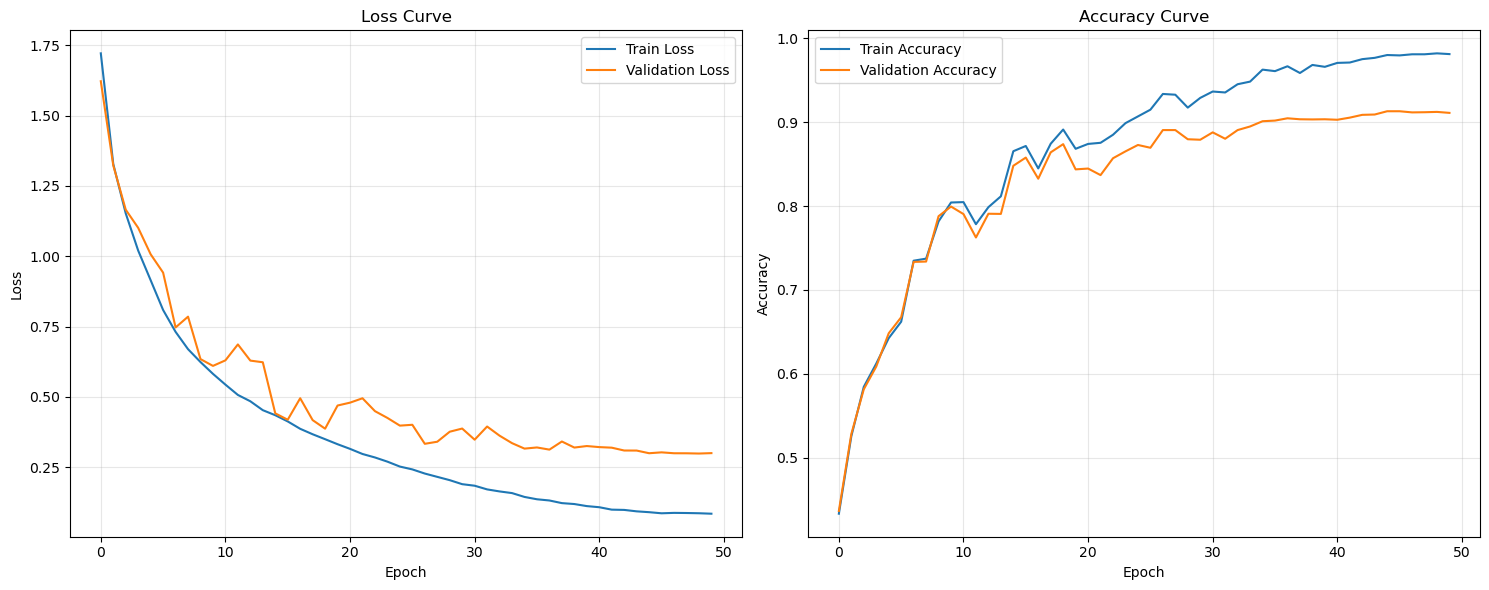


Loading best model for final evaluation...
✅ Model loaded from best_cifar10_improved_model.pkl

🏆 FINAL EVALUATION (Best Model):
  Test Loss: 0.3370
  Test Accuracy: 0.9026
  Test Precision: 0.8985
  Test Recall: 0.8976
  Test F1: 0.8941

Training completed!


In [11]:
main()